In [ ]:
import warnings
from dataclasses import dataclass
from statistics import median

import numpy as np
import pandas as pd
from datasets import load_dataset
from jiwer import process_characters
from plotnine import (
    aes,
    element_blank,
    element_text,
    facet_grid,
    geom_abline,
    geom_boxplot,
    geom_histogram,
    geom_line,
    geom_point,
    geom_ribbon,
    ggplot,
    labs,
    scale_color_manual,
    scale_fill_manual,
    scale_x_continuous,
    scale_y_continuous,
    theme,
    theme_bw,
    ylim,
)
from scipy.stats import ttest_ind, ttest_rel
from sklearn.metrics import matthews_corrcoef, mutual_info_score

warnings.filterwarnings("ignore")

id_map = {
    "t1": "Faster",
    "t2": "Average",
    "t3": "Slower"
}

modality_map = {
    "no_highlight": "No Highlight",
    "oracle": "Oracle",
    "supervised": "Supervised",
    "unsupervised": "Unsupervised"
}
rev_modality_map = {v: k for k, v in modality_map.items()}

lang_map = {
    "ita": "English - Italian",
    "nld": "English - Dutch"
}

task_map = {
    "pretask": "Pre",
    "main": "Main",
    "posttask": "Post"
}

domain_map = {
    "biomedical": "Biomedical",
    "social": "Social Media"
}

qe4pe_map = {
    **id_map,
    **modality_map,
    **lang_map,
    **task_map,
    **domain_map
}

full_pretask = load_dataset("gsarti/qe4pe", "pretask")["train"].to_pandas()
full_main = load_dataset("gsarti/qe4pe", "main")["train"].to_pandas()
full_posttask = load_dataset("gsarti/qe4pe", "posttask")["train"].to_pandas()

# Entries with issues are excluded from main split analysis
pretask = full_pretask[(~full_pretask["has_issue"]) & (full_pretask["translator_main_id"] != "no_highlight_t4")]
posttask = full_posttask[(~full_posttask["has_issue"]) & (full_posttask["translator_main_id"] != "no_highlight_t4")]
main = full_main[(~full_main["has_issue"]) & (full_main["translator_main_id"] != "no_highlight_t4")]

print(full_pretask.shape, pretask.shape)
print(full_posttask.shape, posttask.shape)
print(full_main.shape, main.shape)

(950, 96) (912, 96)
(1200, 96) (1150, 96)
(8100, 106) (7560, 106)


# Productivity Assessment

In [2]:
def get_doc_edit_times(df: pd.DataFrame):
    doc_edit_times = (
    df[["translator_main_id", "doc_id", "tgt_lang", "wmt_category", "highlight_modality", "doc_edit_time_filtered"]]
        .groupby(["translator_main_id",  "doc_id", "tgt_lang", "highlight_modality",])
        .first()
        .reset_index()
    )

    doc_chars = (
        df[["translator_main_id", "doc_id", "tgt_lang", "wmt_category", "highlight_modality", "mt_num_chars"]]
            .groupby(["translator_main_id",  "doc_id", "tgt_lang", "highlight_modality",])
            .sum()
            .reset_index()
        )
    doc_edit_times["mt_num_chars"] = doc_chars["mt_num_chars"]
    doc_edit_times["char_per_min"] = (doc_edit_times["mt_num_chars"] / (doc_edit_times["doc_edit_time_filtered"] / 60))
    doc_edit_times.replace([np.inf, -np.inf], np.nan, inplace=True)
    doc_edit_times.fillna(-1, inplace=True)
    return doc_edit_times

def gettrans(df, translator_main_id, lang = None):
    if not lang:
        return df[df["translator_main_id"] == translator_main_id]
    return df[(df["translator_main_id"] == translator_main_id) & (df["tgt_lang"] == lang)]

def getmod(df, modality, lang = None):
    if not lang:
        return df[df["highlight_modality"] == modality]
    return df[(df["highlight_modality"] == modality) & (df["tgt_lang"] == lang)]

def getspeed(df, speed, lang = None):
    if not lang:
        return df[df["translator_main_id"].str.contains(speed)]
    return df[(df["translator_main_id"].str.contains(speed)) & (df["tgt_lang"] == lang)]

pre_doc_edit_times = get_doc_edit_times(pretask)
main_doc_edit_times = get_doc_edit_times(main)
post_doc_edit_times = get_doc_edit_times(posttask)
print("Pretask", pre_doc_edit_times["char_per_min"].describe())
print("Main", main_doc_edit_times["char_per_min"].describe())
print("Posttask", post_doc_edit_times["char_per_min"].describe())

domains = ["biomedical", "social", "all"]
modalities = ["all high", "no_highlight", "oracle", "unsupervised", "supervised", "all"]
speed_levels = {
    "t1": "fast",
    "t2": "avg",
    "t3": "slow",
    "all": "all"
}

dic_cpm = {}

for lang, lang_str in lang_map.items():
    print(lang_str + "\n====================")
    print(f"{'Speed':<7} {'Domain':<10} {'Modality':<14} {'Pretask':<14} {'Main':<6} {'Posttask':<14}")
    for speed_id, speed in speed_levels.items():
        for domain in domains:
            for mod in modalities:
                f_mod = modalities[1:-1] if mod == "all" else modalities[2:-1] if mod == "all high" else [mod]
                f_domain = [domain] if domain != "all" else domains[:-1]
                if speed_id != "all":
                    f_translators = [f"{mod}_{speed_id}" for mod in f_mod]
                else:
                    f_translators = [f"{mod}_{speed_id}" for mod in f_mod for speed_id in list(speed_levels.keys())[:-1]]

                cpm_pretask = pre_doc_edit_times[
                    (pre_doc_edit_times["tgt_lang"] == lang) &
                    (pre_doc_edit_times["wmt_category"].isin(f_domain)) &
                    (pre_doc_edit_times["translator_main_id"].isin(f_translators))
                ]
                cpm_main = main_doc_edit_times[
                    (main_doc_edit_times["tgt_lang"] == lang) &
                    (main_doc_edit_times["wmt_category"].isin(f_domain)) &
                    (main_doc_edit_times["translator_main_id"].isin(f_translators))
                ]
                cpm_posttask = post_doc_edit_times[
                    (post_doc_edit_times["tgt_lang"] == lang) &
                    (post_doc_edit_times["wmt_category"].isin(f_domain)) &
                    (post_doc_edit_times["translator_main_id"].isin(f_translators))
                ]
                dic_cpm[(lang, speed, domain, mod, "pre")] = list(cpm_pretask["char_per_min"])
                dic_cpm[(lang, speed, domain, mod, "main")] = list(cpm_main["char_per_min"])
                dic_cpm[(lang, speed, domain, mod, "post")] = list(cpm_posttask["char_per_min"])
                pre_median_cpm = cpm_pretask["char_per_min"].median()
                main_median_cpm = cpm_main["char_per_min"].median()
                post_median_cpm = cpm_posttask["char_per_min"].median(skipna=True)
                print(f"{speed:<7} {domain:<10} {mod:<14} {round(pre_median_cpm, 2):<6} (x{round(pre_median_cpm/main_median_cpm, 2):<4}) {round(main_median_cpm, 2):<6} {round(post_median_cpm, 2):<6} (x{round(post_median_cpm/main_median_cpm, 2):<4})")
        print("-" * 10)
    print("-" * 10)
print("\n\n")

no_highlight_main_cpm = dic_cpm[("ita", "all", "all", "no_highlight", "main")] + dic_cpm[("nld", "all", "all", "no_highlight", "main")]
oracle_main_cpm = dic_cpm[("ita", "all", "all", "oracle", "main")] + dic_cpm[("nld", "all", "all", "oracle", "main")]
supervised_main_cpm = dic_cpm[("ita", "all", "all", "supervised", "main")] + dic_cpm[("nld", "all", "all", "supervised", "main")]
unsupervised_main_cpm = dic_cpm[("ita", "all", "all", "unsupervised", "main")] + dic_cpm[("nld", "all", "all", "unsupervised", "main")]

no_highlight_post_cpm = dic_cpm[("ita", "all", "all", "no_highlight", "post")] + dic_cpm[("nld", "all", "all", "no_highlight", "post")]
oracle_post_cpm = dic_cpm[("ita", "all", "all", "oracle", "post")] + dic_cpm[("nld", "all", "all", "oracle", "post")]
supervised_post_cpm = dic_cpm[("ita", "all", "all", "supervised", "post")] + dic_cpm[("nld", "all", "all", "supervised", "post")]
unsupervised_post_cpm = dic_cpm[("ita", "all", "all", "unsupervised", "post")] + dic_cpm[("nld", "all", "all", "unsupervised", "post")]

print(len(no_highlight_main_cpm), len(oracle_main_cpm), len(supervised_main_cpm), len(unsupervised_main_cpm))
print(len(no_highlight_post_cpm), len(oracle_post_cpm), len(supervised_post_cpm), len(unsupervised_post_cpm))



Pretask count     144.000000
mean      152.910440
std       157.755160
min        19.977503
25%        68.595163
50%       104.130066
75%       186.528763
max      1152.439024
Name: char_per_min, dtype: float64
Main count    1200.000000
mean      267.262104
std       346.595534
min        -1.000000
25%        98.932012
50%       151.877527
75%       280.468947
max      4605.000000
Name: char_per_min, dtype: float64
Posttask count     184.000000
mean      222.543386
std       274.866278
min        31.431353
25%        84.279696
50%       125.053842
75%       231.059307
max      1913.076923
Name: char_per_min, dtype: float64
English - Italian
Speed   Domain     Modality       Pretask        Main   Posttask      
fast    biomedical all high       218.04 (x1.07) 204.1  389.86 (x1.91)
fast    biomedical no_highlight   199.81 (x0.25) 812.81 355.14 (x0.44)
fast    biomedical oracle         487.51 (x0.95) 513.85 502.14 (x0.98)
fast    biomedical unsupervised   202.26 (x1.15) 175.3  nan    (xna

- Productivity over biomedical texts is always higher than over social media texts across all stages, with the gap being especially evident for faster translators.
- Absence of highlights in the post-task generally made translators slower on social media texts, but faster in biomedical texts. Out of 9 translators per language working on modalities with highlights, 2/3 were up to twice as fast without highlights in biomedical texts across both directions, while 2/3 were up to three times slower on social media texts in the same setting.

Main: 39720 , Pretask: 5229 , Posttask: 6412


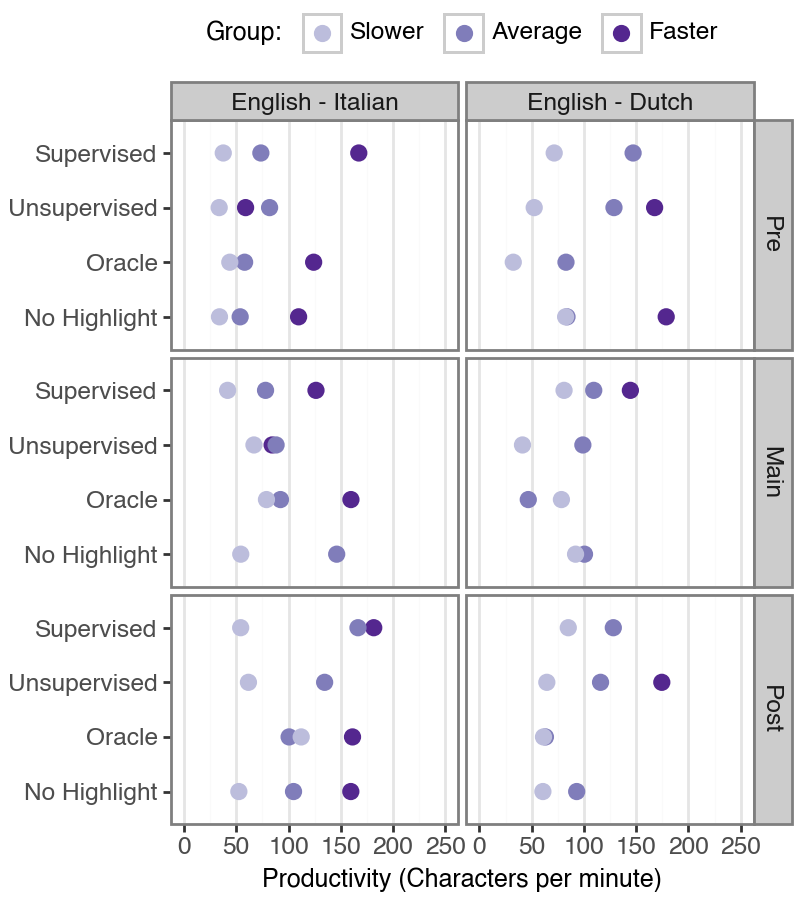

Lang              Modality       ID      Pretask        Main   Posttask      
English - Italian No Highlight   Faster  109.66 (x0.31) 358.7  159.63 (x0.45)
English - Italian No Highlight   Average 53.74  (x0.37) 146.11 104.8  (x0.72)
English - Italian No Highlight   Slower  33.94  (x0.63) 54.3   52.49  (x0.97)
English - Italian No Highlight   Avg.    65.78  (x0.35) 186.37 105.64 (x0.57)
----------
English - Italian Oracle         Faster  124.06 (x0.78) 159.74 161.24 (x1.01)
English - Italian Oracle         Average 57.99  (x0.63) 92.29  100.58 (x1.09)
English - Italian Oracle         Slower  43.82  (x0.56) 78.9   112.13 (x1.42)
English - Italian Oracle         Avg.    75.29  (x0.68) 110.31 124.65 (x1.13)
----------
English - Italian Unsupervised   Faster  58.92  (x0.7 ) 84.31  112.13 (x1.33)
English - Italian Unsupervised   Average 81.9   (x0.93) 88.11  134.56 (x1.53)
English - Italian Unsupervised   Slower  33.65  (x0.5 ) 66.93  61.66  (x0.92)
English - Italian Unsupervised   Avg.    5

In [ ]:
TIME_FIELD = "doc_edit_time_filtered"

MAIN_NUM_SRC_CHARS = main.groupby(["translator_main_id", "tgt_lang"])["src_num_chars"].sum().reset_index().loc[0, "src_num_chars"]
PRETASK_NUM_SRC_CHARS = pretask.groupby(["translator_pretask_id", "tgt_lang"])["src_num_chars"].sum().reset_index().loc[0, "src_num_chars"]
POSTTASK_NUM_SRC_CHARS = posttask.groupby(["translator_main_id", "tgt_lang"])["src_num_chars"].sum().reset_index().loc[0, "src_num_chars"]

print("Main:", MAIN_NUM_SRC_CHARS, ", Pretask:", PRETASK_NUM_SRC_CHARS, ", Posttask:", POSTTASK_NUM_SRC_CHARS)

def get_char_per_sec_df(df: pd.DataFrame, num_src_chars: int, task_name: str, time_field: str = TIME_FIELD):
    df_new = (
        df
        [["translator_main_id", "doc_id", "tgt_lang", "highlight_modality", time_field]]
        .groupby(["translator_main_id",  "doc_id", "tgt_lang", "highlight_modality",])
        .first()
        .reset_index()
        .groupby(["translator_main_id", "tgt_lang", "highlight_modality"])
        .sum()
        .drop(columns=["doc_id"])
        .reset_index()
    )
    df_new["id"] = df_new["translator_main_id"].str[-2:]
    df_new["id"] = df_new["id"].map(id_map)
    df_new["task"] = task_map[task_name]
    df_new["char_per_min"] = (num_src_chars / (df_new[time_field] / 60))
    df_new["highlight_modality"] = df_new["translator_main_id"].str[:-3]
    df_new["highlight_modality"] = df_new["highlight_modality"].map(modality_map)
    df_new["tgt_lang"] = df_new["tgt_lang"].map(lang_map)
    return df_new

char_per_sec = []
char_per_sec_pre = get_char_per_sec_df(pretask, PRETASK_NUM_SRC_CHARS, "pretask")
char_per_sec_main = get_char_per_sec_df(main, MAIN_NUM_SRC_CHARS, "main")
char_per_sec_post = get_char_per_sec_df(posttask, POSTTASK_NUM_SRC_CHARS, "posttask")
char_per_sec_df = pd.concat([char_per_sec_pre, char_per_sec_main, char_per_sec_post])
char_per_sec_df.id = pd.Categorical(char_per_sec_df.id, ordered=True, categories=["Slower", "Average", "Faster"])
char_per_sec_df.tgt_lang = pd.Categorical(char_per_sec_df.tgt_lang, ordered=True, categories=["English - Italian", "English - Dutch"])
char_per_sec_df.task = pd.Categorical(char_per_sec_df.task, ordered=True, categories=["Pre", "Main", "Post"])
char_per_sec_df.highlight_modality = pd.Categorical(char_per_sec_df.highlight_modality, ordered=True, categories=["No Highlight", "Oracle", "Unsupervised", "Supervised"])

MAX_CHAR_PER_MIN = 250

plot = (
    ggplot(char_per_sec_df, aes(x="char_per_min", y="highlight_modality", color="id"))
    + geom_point(size=2.5, alpha=1)  # Larger points
    + facet_grid("task~tgt_lang")  # Facet by task and language
    + scale_color_manual(values={"Slower":'#bcbddc', "Average":"#807dba", "Faster": "#54278f"})  # Colorblind-friendly palette
    + scale_x_continuous(limits=(0, MAX_CHAR_PER_MIN))
    + labs(
        x="Productivity (Characters per minute)",
        color="Group:"
    )
    + theme_bw()
    + theme(
        legend_position="top",  # Legend at the bottom
        panel_grid_major_y=element_blank(),  # Remove vertical gridlines
        panel_grid_minor_y=element_blank(),
        figure_size=(4, 4.5),
        axis_title_y=element_blank(),
        axis_title_x=element_text(size=9),
        legend_title=element_text(size=9),
    )
)
plot.save("../figures/productivity.pdf")
plot.save("../figures/productivity.svg")
plot.show()

print(f"{'Lang':17} {'Modality':<14} {'ID':<7} {'Pretask':<14} {'Main':<6} {'Posttask':<14}")
for lang in ["English - Italian", "English - Dutch"]:
    for mod in ["No Highlight", "Oracle", "Unsupervised", "Supervised"]:
        avg_dic = {(lang, mod, 'Pre'): [], (lang, mod, 'Main'): [], (lang, mod, 'Post'): []}
        for id in range(1,4):
            # Select the rows that have the modality and the id
            rows = char_per_sec_df[
                (char_per_sec_df["translator_main_id"] == f"{rev_modality_map[mod]}_t{id}") &
                (char_per_sec_df["tgt_lang"] == lang)
            ]
            if rows.empty:
                continue
            cpm_pretask = rows[rows["task"] == "Pre"].reset_index().loc[0]["char_per_min"]
            cpm_main = rows[rows["task"] == "Main"].reset_index().loc[0]["char_per_min"]
            if not rows[rows["task"] == "Post"].empty:
                cpm_posttask = rows[rows["task"] == "Post"].reset_index().loc[0]["char_per_min"]
            avg_dic[(lang, mod, 'Pre')] += [cpm_pretask]
            avg_dic[(lang, mod, 'Main')] += [cpm_main]
            avg_dic[(lang, mod, 'Post')] += [cpm_posttask]
            print(f"{lang:<17} {mod:<14} {id_map[f't{id}']:<7} {round(cpm_pretask, 2):<6} (x{round(cpm_pretask/cpm_main, 2):<4}) {round(cpm_main, 2):<6} {round(cpm_posttask, 2):<6} (x{round(cpm_posttask/cpm_main, 2):<4})")
        avg_pre = sum(avg_dic[(lang, mod, 'Pre')]) / len(avg_dic[(lang, mod, 'Pre')])
        avg_main = sum(avg_dic[(lang, mod, 'Main')]) / len(avg_dic[(lang, mod, 'Main')])
        avg_post = sum(avg_dic[(lang, mod, 'Post')]) / len(avg_dic[(lang, mod, 'Post')])
        print(f"{lang:<17} {mod:<14} {'Avg.':<7} {round(avg_pre, 2):<6} (x{round(avg_pre/avg_main, 2):<4}) {round(avg_main, 2):<6} {round(avg_post, 2):<6} (x{round(avg_post/avg_main, 2):<4})")
        print("-" * 10)
    print("-" * 10)

# Highlights Overlap Across Categories

In [85]:
from pprint import pprint

def get_df(mod, lang):
    return main[(main["translator_main_id"] == f"{mod}_t1") & (main["tgt_lang"] == lang)].reset_index(drop=True)

def get_high(df, idx):
    return [(x["start"],x["end"]) for x in eval(df.loc[idx, "highlights"])]

def get_substring_indices(substring_list):
    # Convert the list of tuples into a set of character indices
    indices = set()
    for start, end in substring_list:
        indices.update(range(start, end))
    return indices

overlap_results = {}
for lang in ["ita", "nld"]:
    oracle_df = get_df("oracle", lang)
    supervised_df = get_df("supervised", lang)
    unsupervised_df = get_df("unsupervised", lang)
    for idx in range(len(oracle_df)):
        mt = oracle_df.loc[idx, "mt_text"]

        # Get the character indices for each list
        oracle_indices = get_substring_indices(get_high(oracle_df, idx))
        supervised_indices = get_substring_indices(get_high(supervised_df, idx))
        unsupervised_indices = get_substring_indices(get_high(unsupervised_df, idx))

        # Store all lists in a dictionary for easy access
        lists = {
            'oracle': oracle_indices,
            'supervised': supervised_indices,
            'unsupervised': unsupervised_indices,
        }

        # Compute the overlap between all pairs of lists
        for name1, indices_a in lists.items():
            for name2, indices_b in lists.items():
                if name1 != name2:
                    # Calculate the intersection of the two sets
                    intersection = indices_a.intersection(indices_b)
                    # Calculate the proportion of overlap
                    if len(indices_a) == 0:
                        overlap = 0.0
                    else:
                        overlap = len(intersection) / len(indices_a)
                    # Store the result
                    key = f"{name1}_overlap_w_{name2}"
                    if key not in overlap_results:
                        overlap_results[key] = []
                    overlap_results[key].append(overlap)
pprint({k: round(sum(v) / len(v),2) for k, v in overlap_results.items()})

{'oracle_overlap_w_supervised': 0.22,
 'oracle_overlap_w_unsupervised': 0.27,
 'supervised_overlap_w_oracle': 0.3,
 'supervised_overlap_w_unsupervised': 0.29,
 'unsupervised_overlap_w_oracle': 0.33,
 'unsupervised_overlap_w_supervised': 0.24}


| ALL                 | **... is also in Oracle** | **... is also in Supervised** | **... is also in Unsupervised** |
|---------------------|-----------------------|---------------------------|----------------------------|
| **Which proportion of Oracle**    | 1.00                  | 0.22                      | 0.27                       |
| **Which proportion of Supervised**| 0.30                  | 1.00                      | 0.29                       |
| **Which proportion of Unsupervised**| 0.33                | 0.24                      | 1.00                       |

and

| ITA                 | **... is also in Oracle** | **... is also in Supervised** | **... is also in Unsupervised** |
|---------------------|-----------------------|---------------------------|----------------------------|
| **Which proportion of Oracle**    | 1.00                  | 0.21                      | 0.23                       |
| **Which proportion of Supervised**| 0.27                  | 1.00                      | 0.28                       |
| **Which proportion of Unsupervised**| 0.28                | 0.25                      | 1.00                       |

and

| NLD                 | **... is also in Oracle** | **... is also in Supervised** | **... is also in Unsupervised** |
|---------------------|-----------------------|---------------------------|----------------------------|
| **Which proportion of Oracle**    | 1.00                  | 0.23                      | 0.32                       |
| **Which proportion of Supervised**| 0.33                  | 1.00                      | 0.29                       |
| **Which proportion of Unsupervised**| 0.38                | 0.23                      | 1.00                       |

# Editing Choices

In this section, we will compute the number of edits that are within and outside the highlights across target languages, participant, highlight modalties and text categories. Importantly, we will test whether the findings regarding in/out edit proportion hold for "projected highlights" transfered from other modalities to the `no_highlight` setting, to test the causal effect of highlights on edits.

=== EDIT IN HIGHLIGHT RATE ===
ita biomedical oracle supervised = *** 1.2172539225258494e-11
ita biomedical oracle unsupervised = na 0.40101530233081717
ita biomedical supervised unsupervised = *** 8.249823136611917e-12
ita social oracle supervised = *** 9.681128173202857e-31
ita social oracle unsupervised = *** 5.597316107509563e-17
ita social supervised unsupervised = ** 0.00022955326318262862
nld biomedical oracle supervised = *** 7.587802063084806e-13
nld biomedical oracle unsupervised = na 0.1365714566427762
nld biomedical supervised unsupervised = *** 3.87842602510411e-09
nld social oracle supervised = *** 7.431500109808851e-14
nld social oracle unsupervised = *** 4.1751731238398595e-10
nld social supervised unsupervised = na 0.22135595960160856
=== EDIT RATE ===
ita biomedical no_highlight oracle = *** 1.59183949177741e-14
ita biomedical no_highlight supervised = *** 7.748776088679979e-43
ita biomedical no_highlight unsupervised = *** 4.4103781211386954e-24
ita biomedical oracle

/Users/gsarti/Documents/projects/qe4pe/venv/lib/python3.11/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 4 x 3 in image.
/Users/gsarti/Documents/projects/qe4pe/venv/lib/python3.11/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: ../figures/edit_rate.pdf
/Users/gsarti/Documents/projects/qe4pe/venv/lib/python3.11/site-packages/plotnine/layer.py:284: PlotnineWarning: stat_boxplot : Removed 229 rows containing non-finite values.
/Users/gsarti/Documents/projects/qe4pe/venv/lib/python3.11/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 4 x 3 in image.
/Users/gsarti/Documents/projects/qe4pe/venv/lib/python3.11/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: ../figures/edit_rate.svg
/Users/gsarti/Documents/projects/qe4pe/venv/lib/python3.11/site-packages/plotnine/layer.py:284: PlotnineWarning: stat_boxplot : Removed 229 rows containing non-finite values.
/Users/gsarti/Documents/projects/qe4pe/venv/lib/python3.11/site-packages/plotn

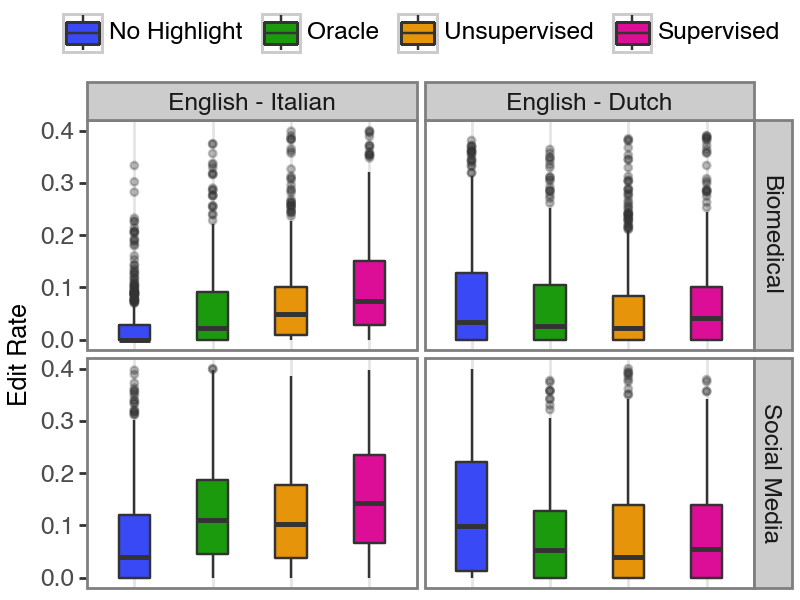

/Users/gsarti/Documents/projects/qe4pe/venv/lib/python3.11/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 4 x 3 in image.
/Users/gsarti/Documents/projects/qe4pe/venv/lib/python3.11/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: ../figures/highlighted_edit_rate.pdf
/Users/gsarti/Documents/projects/qe4pe/venv/lib/python3.11/site-packages/plotnine/layer.py:284: PlotnineWarning: stat_boxplot : Removed 1392 rows containing non-finite values.
/Users/gsarti/Documents/projects/qe4pe/venv/lib/python3.11/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 4 x 3 in image.
/Users/gsarti/Documents/projects/qe4pe/venv/lib/python3.11/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: ../figures/highlighted_edit_rate.svg
/Users/gsarti/Documents/projects/qe4pe/venv/lib/python3.11/site-packages/plotnine/layer.py:284: PlotnineWarning: stat_boxplot : Removed 1392 rows containing non-finite values.
/Users/gsarti/Documents/projects/qe4pe/venv/lib/pyth

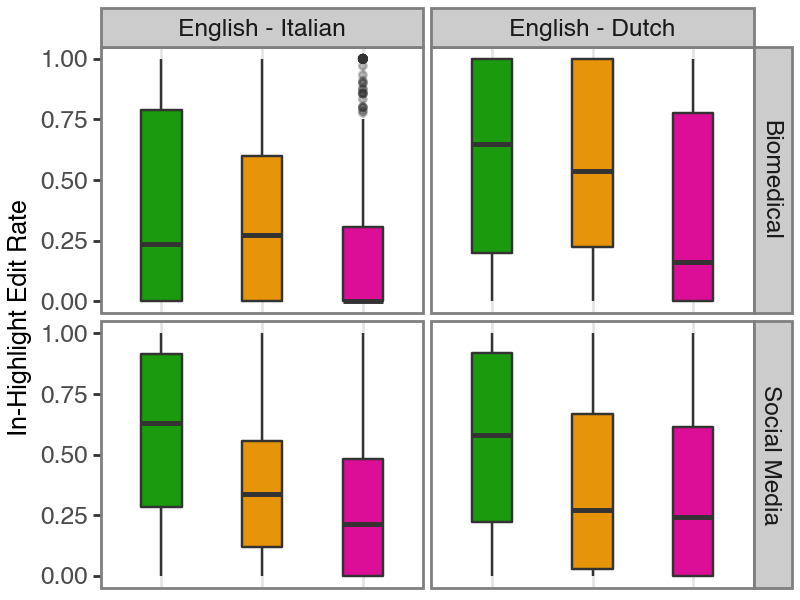

In [115]:
def get_highlight_pos(row):
    return [pos for d in eval(row["highlights"]) for pos in list(range(d["start"], d["end"]))]

def get_edit_pos(row):
    return [
        idx
        for chunk in process_characters(row["mt_text"], row["pe_text"]).alignments[0]
        if chunk.type != "equal"
        for idx in range(chunk.ref_start_idx, chunk.ref_end_idx)
    ]

# Remove no_highlight for editing in highlight analysis
df = main.copy()

df.loc[:, "edit_in_highlight"] = df.apply(lambda row: len(set(get_highlight_pos(row)) & set(get_edit_pos(row))), axis=1)
df.loc[:, "edit_out_highlight"] = df.apply(lambda row: len(set(get_edit_pos(row))) - row.edit_in_highlight, axis=1)
df.loc[:, "edit_total"] = df["edit_in_highlight"] + df["edit_out_highlight"]
df.loc[:, "edit_in_rate"] = df["edit_in_highlight"] / df["edit_total"]
df.loc[:, "edit_rate"] = df["edit_total"] / df["mt_num_chars"]
df = df[["translator_main_id", "tgt_lang", "highlight_modality", "wmt_category", "edit_in_rate", "edit_rate"]]

dfs = {}
for lang in ["ita", "nld"]:
    for domain in ["biomedical", "social"]:
        for modality in ["no_highlight", "oracle", "supervised", "unsupervised"]:
            dfs[f"{lang}_{domain}_{modality}"] = df[(df["tgt_lang"] == lang) & (df["highlight_modality"] == modality) & (df["wmt_category"] == domain)]

def compute_significance(dfs, rate_column, modalities=["oracle", "supervised", "unsupervised"]):
    num_tests = 12 if len(modalities) == 3 else 24
    for lang in ["ita", "nld"]:
        for domain in ["biomedical", "social"]:
            for i, modality_a in enumerate(modalities):
                for modality_b in modalities[i+1:]:
                    pval = ttest_ind(dfs[f"{lang}_{domain}_{modality_a}"][rate_column], dfs[f"{lang}_{domain}_{modality_b}"][rate_column], equal_var=False, nan_policy="omit").pvalue
                    if pval < 0.001 / num_tests:
                        sig = "***"
                    elif pval < 0.01 / num_tests:
                        sig = "**"
                    elif pval < 0.05 / num_tests:
                        sig = "*"
                    else:
                        sig = "na"
                    print(f"{lang} {domain} {modality_a} {modality_b} = {sig} {pval}")

print("=== EDIT IN HIGHLIGHT RATE ===")
compute_significance(dfs, "edit_in_rate")
print("=== EDIT RATE ===")
compute_significance(dfs, "edit_rate", modalities=["no_highlight", "oracle", "supervised", "unsupervised"])

# Create the plot
df.tgt_lang = df.tgt_lang.map(lang_map)
df.tgt_lang = pd.Categorical(df.tgt_lang, ordered=True, categories=["English - Italian", "English - Dutch"])
df.highlight_modality = df.highlight_modality.map(modality_map)
df.wmt_category = df.wmt_category.map(domain_map)
df.wmt_category = pd.Categorical(df.wmt_category, ordered=True, categories=["Biomedical", "Social Media"])

df_highlight_only = df[df["highlight_modality"] != "No Highlight"].copy()
df_highlight_only.highlight_modality = pd.Categorical(df_highlight_only.highlight_modality, ordered=True, categories=["Oracle", "Unsupervised", "Supervised"])
df.highlight_modality = pd.Categorical(df.highlight_modality, ordered=True, categories=["No Highlight", "Oracle", "Unsupervised", "Supervised"])

plot = (
    ggplot(df, aes(x='highlight_modality', y='edit_rate', fill="highlight_modality")) +
    geom_boxplot(width=0.4, outlier_alpha=0.3, outlier_size=1) +
    facet_grid('wmt_category~tgt_lang') +
    scale_y_continuous(limits=(0, 0.4)) +
    theme_bw() +
    labs(
        x='Highlight Modality',
        y='Edit Rate',
    ) +
    theme(
        legend_position="top",  # Legend at the top
        panel_grid_major_y=element_blank(),  # Remove vertical gridlines
        panel_grid_minor_y=element_blank(),
        figure_size=(4, 3),
        axis_title_y=element_text(size=9),
        axis_title_x=element_blank(),
        legend_title=element_blank(),
        axis_text_x=element_blank(),
        axis_ticks_x=element_blank(),
    )
    + scale_fill_manual(values=["#3949f5", "#1c9a0e", "#e6950a", "#dc0d97"])
)

plot.save("../figures/edit_rate.pdf")
plot.save("../figures/edit_rate.svg")
plot.show()

plot = (
    ggplot(df_highlight_only, aes(x='highlight_modality', y='edit_in_rate', fill="highlight_modality")) +
    geom_boxplot(width=0.4, outlier_alpha=0.3, outlier_size=1) +
    facet_grid('wmt_category~tgt_lang') +
    theme_bw() +
    labs(
        x='Highlight Modality',
        y='In-Highlight Edit Rate',
    ) +
    theme(
        legend_position="none",
        panel_grid_major_y=element_blank(),  # Remove vertical gridlines
        panel_grid_minor_y=element_blank(),
        figure_size=(4, 3),
        axis_title_y=element_text(size=9),
        axis_title_x=element_blank(),
        axis_text_x=element_blank(),
        axis_ticks_x=element_blank(),
    )
    + scale_fill_manual(values=["#1c9a0e", "#e6950a", "#dc0d97"])

)

plot.save("../figures/highlighted_edit_rate.pdf")
plot.save("../figures/highlighted_edit_rate.svg")
plot.show()


In [ ]:
@dataclass
class HighlightEditEntry:
    n_edited: int
    n_not_edited: int
    n_highlighted: int
    n_not_highlighted: int
    n_highlighted_edited: int
    n_edited_not_highlighted: int
    n_highlighted_not_edited: int
    p_highlighted: float
    p_edited: float
    p_edited_given_highlighted: float
    p_edited_given_not_highlighted: float
    lr_edited: float
    p_highlighted_given_edited: float
    p_highlighted_given_not_edited: float
    lr_highlighted: float
    edits: list[bool]
    highlights: list[bool]
    h_highlights: float
    h_edits: float
    max_mi: float
    mi: float
    mcc: float
    nmi: float
    f1: float


def get_indices(text_length, spans_indices):
    indices = np.zeros(text_length, dtype=bool)
    for start, end in spans_indices:
        indices[start:end] = True
    return indices

def calculate_entropy(x: np.ndarray) -> float:
    """Calculate entropy of a binary array."""
    p = np.mean(x)
    if p in (0, 1):
        return 0
    return -(p * np.log2(p) + (1-p) * np.log2(1-p))

def compute_in_out_edits(
        edited_spans_indices, highlighted_span_indices, text_length
    ) -> HighlightEditEntry:

    def get_chars_in_spans(spans_indices):
        return sum(end - start for start, end in spans_indices)

    n_edited = get_chars_in_spans(edited_spans_indices)
    n_not_edited = text_length - n_edited
    n_highlighted = get_chars_in_spans(highlighted_span_indices)
    n_not_highlighted = text_length - n_highlighted

    # Find intersecting edited spans within highlighted spans
    highlighted_edited_spans = [
        (start, end)
        for edited_span in edited_spans_indices
        for highlight_span in highlighted_span_indices
        if (start := max(edited_span[0], highlight_span[0])) <
            (end := min(edited_span[1], highlight_span[1]))
    ]

    n_highlighted_edited = n_edited_highlighted = get_chars_in_spans(highlighted_edited_spans)
    n_edited_not_highlighted = n_edited - n_edited_highlighted
    n_highlighted_not_edited = n_highlighted - n_highlighted_edited
    p_highlighted = n_highlighted / text_length if text_length > 0 else 0
    p_edited = n_edited / text_length if text_length > 0 else 0
    p_edited_given_highlighted = n_edited_highlighted / n_highlighted if n_highlighted > 0 else 0
    p_edited_given_not_highlighted = n_edited_not_highlighted / n_not_highlighted if n_not_highlighted > 0 else 0
    lr_edited = p_edited_given_highlighted / p_edited_given_not_highlighted if p_edited_given_not_highlighted > 0 else 0
    p_highlighted_given_edited = n_highlighted_edited / n_edited if n_edited > 0 else 0
    p_highlighted_given_not_edited = n_highlighted_not_edited / n_not_edited if n_not_edited > 0 else 0
    lr_highlighted = p_highlighted_given_edited / p_highlighted_given_not_edited if p_highlighted_given_not_edited > 0 else 0

    edits: np.ndarray = get_indices(text_length, edited_spans_indices)
    highlights: np.ndarray = get_indices(text_length, highlighted_span_indices)

    # Calculate entropies and mutual information
    h_highlights = calculate_entropy(highlights)
    h_edits = calculate_entropy(edits)
    max_mi = min(h_highlights, h_edits)
    mi = mutual_info_score(highlights, edits)
    mcc = matthews_corrcoef(highlights, edits)
    nmi = mi / max_mi if max_mi > 0 else 0

    f1 = 2 * (p_edited_given_highlighted * p_highlighted_given_edited) / (p_edited_given_highlighted + p_highlighted_given_edited) if (p_edited_given_highlighted + p_highlighted_given_edited) > 0 else 0.0

    return HighlightEditEntry(
        n_edited=n_edited,
        n_not_edited=n_not_edited,
        n_highlighted=n_highlighted,
        n_not_highlighted=n_not_highlighted,
        n_highlighted_edited=n_highlighted_edited,
        n_edited_not_highlighted=n_edited_not_highlighted,
        n_highlighted_not_edited=n_highlighted_not_edited,
        p_highlighted=p_highlighted,
        p_edited=p_edited,
        p_edited_given_highlighted=p_edited_given_highlighted,
        p_edited_given_not_highlighted=p_edited_given_not_highlighted,
        lr_edited=lr_edited,
        p_highlighted_given_edited=p_highlighted_given_edited,
        p_highlighted_given_not_edited=p_highlighted_given_not_edited,
        lr_highlighted=lr_highlighted,
        edits=edits.tolist(),
        highlights=highlights.tolist(),
        h_highlights=h_highlights,
        h_edits=h_edits,
        max_mi=max_mi,
        mi=mi,
        mcc=mcc,
        nmi=nmi,
        f1=f1
    )


def get_edit_highlight_char_overlap(
        mt_text: str,
        pe_text: str,
        highlights: str,
        highlight_levels: list[str] = ["minor", "major"]
    ) -> HighlightEditEntry:
    align_chars = process_characters(mt_text, pe_text)
    edited_spans = [
        (a.ref_start_idx, a.ref_end_idx)
        for a in align_chars.alignments[0] if a.type != "equal"
    ]
    highlighted_spans = [(e["start"], e["end"]) for e in eval(highlights) if e["severity"] in highlight_levels]
    try:
        return compute_in_out_edits(edited_spans, highlighted_spans, len(mt_text))
    except Exception as e:
        print(mt_text)
        print(pe_text)
        print(highlights)
        raise Exception from e


@dataclass
class HighlightEditProportionOutput:
    edited_chars: list[int]
    non_edited_chars: list[int]
    in_highlight_num_chars: list[int]
    out_highlight_num_chars: list[int]
    in_highlight_edited_chars: list[int]
    out_highlight_edited_chars: list[int]
    edit_proportion: list[float]
    highlight_proportion: list[float]
    in_highlight_edit_proportion: list[float]
    out_highlight_edit_proportion: list[float]
    lr_edited: list[float]
    in_edits_highlight_proportion: list[float]
    out_edits_highlight_proportion: list[float]
    lr_highlighted: list[float]
    edits: list[bool]
    highlights: list[bool]
    h_highlights: list[float]
    h_edits: list[float]
    max_mi: list[float]
    mi: list[float]
    mcc: list[float]
    nmi: list[float]
    f1: list[float]
    tot_edited_chars: int
    tot_non_edited_chars: int
    tot_in_highlight_num_chars: int
    tot_out_highlight_num_chars: int
    tot_in_highlight_edited_chars: int
    tot_out_highlight_edited_chars: int
    tot_edit_proportion: float # P(E)
    tot_highlight_proportion: float # P(E)
    tot_in_highlight_edit_proportion: float # P(E | H)
    tot_out_highlight_edit_proportion: float # P(E | ~H)
    tot_lr_edited: float # P(E | H) / P(E | ~H)
    tot_in_edits_highlight_proportion: float # P(H | E)
    tot_out_edits_highlight_proportion: float # P(H | ~E)
    tot_lr_highlighted: float # P(H | E) / P(H | ~E)
    tot_h_highlights: float
    tot_h_edits: float
    tot_max_mi: float
    tot_mi: float
    tot_mcc: float
    tot_nmi: float
    tot_f1: float
    avg_edited_chars: float
    avg_non_edited_chars: float
    avg_in_highlight_num_chars: float
    avg_out_highlight_num_chars: float
    avg_in_highlight_edited_chars: float
    avg_out_highlight_edited_chars: float
    avg_edit_proportion: float
    avg_highlight_proportion: float
    avg_in_highlight_edit_proportion: float
    avg_out_highlight_edit_proportion: float
    avg_lr_edited: float
    avg_in_edits_highlight_proportion: float
    avg_out_edits_highlight_proportion: float
    avg_lr_highlighted: float
    avg_h_highlights: float
    avg_h_edits: float
    avg_max_mi: float
    avg_mi: float
    avg_mcc: float
    avg_nmi: float
    avg_f1: float
    median_edited_chars: float
    median_non_edited_chars: float
    median_in_highlight_num_chars: float
    median_out_highlight_num_chars: float
    median_in_highlight_edited_chars: float
    median_out_highlight_edited_chars: float
    median_edit_proportion: float
    median_highlight_proportion: float
    median_in_highlight_edit_proportion: float
    median_out_highlight_edit_proportion: float
    median_lr_edited: float
    median_in_edits_highlight_proportion: float
    median_out_edits_highlight_proportion: float
    median_lr_highlighted: float
    median_h_highlights: float
    median_h_edits: float
    median_max_mi: float
    median_mi: float
    median_mcc: float
    median_nmi: float
    median_f1: float


    @classmethod
    def from_highlight_edit_entry_list(cls, entries: list[HighlightEditEntry]) -> "HighlightEditProportionOutput":
        # Lists of individual values
        edited_chars = [entry.n_edited for entry in entries]
        non_edited_chars = [entry.n_not_edited for entry in entries]
        in_highlight_num_chars = [entry.n_highlighted for entry in entries]
        out_highlight_num_chars = [entry.n_not_highlighted for entry in entries]
        in_highlight_edited_chars = [entry.n_highlighted_edited for entry in entries]
        out_highlight_edited_chars = [entry.n_edited_not_highlighted for entry in entries]
        highlighted_not_edited_chars = [entry.n_highlighted_not_edited for entry in entries]
        edit_proportion = [entry.p_edited for entry in entries]
        highlight_proportion = [entry.p_highlighted for entry in entries]
        in_highlight_edit_proportion = [entry.p_edited_given_highlighted for entry in entries]
        out_highlight_edit_proportion = [entry.p_edited_given_not_highlighted for entry in entries]
        lr_edited = [entry.lr_edited for entry in entries]
        in_edits_highlight_proportion = [entry.p_highlighted_given_edited for entry in entries]
        out_edits_highlight_proportion = [entry.p_highlighted_given_not_edited for entry in entries]
        lr_highlighted = [entry.lr_highlighted for entry in entries]
        edits = [val for entry in entries for val in entry.edits]
        highlights = [val for entry in entries for val in entry.highlights]
        h_highlights = [entry.h_highlights for entry in entries]
        h_edits = [entry.h_edits for entry in entries]
        max_mi = [entry.max_mi for entry in entries]
        mi = [entry.mi for entry in entries]
        mcc = [entry.mcc for entry in entries]
        nmi = [entry.nmi for entry in entries]
        f1 = [entry.f1 for entry in entries]

        # Totals
        tot_edited_chars = sum(edited_chars)
        tot_non_edited_chars = sum(non_edited_chars)
        tot_in_highlight_num_chars = sum(in_highlight_num_chars)
        tot_out_highlight_num_chars = sum(out_highlight_num_chars)
        tot_in_highlight_edited_chars = sum(in_highlight_edited_chars)
        tot_out_highlight_edited_chars = sum(out_highlight_edited_chars)
        tot_out_edits_highlighted_chars = sum(highlighted_not_edited_chars)
        tot_chars = tot_edited_chars + tot_non_edited_chars
        tot_edit_proportion = round(tot_edited_chars / tot_chars, 2)
        tot_highlight_proportion = round(tot_in_highlight_num_chars / tot_chars, 2)
        tot_in_highlight_edit_proportion = round(tot_in_highlight_edited_chars / tot_in_highlight_num_chars, 2) if tot_in_highlight_num_chars > 0 else 0
        tot_out_highlight_edit_proportion = round(tot_out_highlight_edited_chars / tot_out_highlight_num_chars, 2)
        tot_lr_edited = tot_in_highlight_edit_proportion / tot_out_highlight_edit_proportion if tot_out_highlight_edit_proportion != 0 else 0
        tot_in_edits_highlight_proportion = round(tot_in_highlight_edited_chars / tot_edited_chars, 2)
        tot_out_edits_highlight_proportion = round(tot_out_edits_highlighted_chars / tot_non_edited_chars, 2)
        tot_lr_highlighted = tot_in_edits_highlight_proportion / tot_out_edits_highlight_proportion if tot_out_edits_highlight_proportion != 0 else 0
        tot_h_highlights = calculate_entropy(np.array(highlights))
        tot_h_edits = calculate_entropy(np.array(edits))
        tot_max_mi = min(tot_h_highlights, tot_h_edits)
        tot_mi = mutual_info_score(np.array(highlights), np.array(edits))
        tot_mcc = matthews_corrcoef(np.array(highlights), np.array(edits))
        tot_nmi = tot_mi / tot_max_mi if tot_max_mi > 0 else 0
        tot_f1 = 2 * (tot_in_highlight_edit_proportion * tot_in_edits_highlight_proportion) / (tot_in_highlight_edit_proportion + tot_in_edits_highlight_proportion) if (tot_in_highlight_edit_proportion + tot_in_edits_highlight_proportion) > 0 else 0.0

        # Averages
        avg_edited_chars = round(tot_edited_chars / len(entries), 2)
        avg_non_edited_chars = round(tot_non_edited_chars / len(entries), 2)
        avg_in_highlight_num_chars = round(tot_in_highlight_num_chars / len(entries), 2)
        avg_out_highlight_num_chars = round(tot_out_highlight_num_chars / len(entries), 2)
        avg_in_highlight_edited_chars = round(tot_in_highlight_edited_chars / len(entries), 2)
        avg_out_highlight_edited_chars = round(tot_out_highlight_edited_chars / len(entries), 2)
        avg_edit_proportion = round(sum(edit_proportion) / len(entries), 2)
        avg_highlight_proportion = round(sum(highlight_proportion) / len(entries), 2)
        avg_in_highlight_edit_proportion = round(sum(in_highlight_edit_proportion) / len(entries), 2)
        avg_out_highlight_edit_proportion = round(sum(out_highlight_edit_proportion) / len(entries), 2)
        avg_lr_edited = round(sum(lr_edited) / len(entries), 2)
        avg_in_edits_highlight_proportion = round(sum(in_edits_highlight_proportion) / len(entries), 2)
        avg_out_edits_highlight_proportion = round(sum(out_edits_highlight_proportion) / len(entries), 2)
        avg_lr_highlighted = round(sum(lr_highlighted) / len(entries), 2)
        avg_h_highlights = round(sum(h_highlights) / len(entries), 2)
        avg_h_edits = round(sum(h_edits) / len(entries), 2)
        avg_max_mi = round(sum(max_mi) / len(entries), 2)
        avg_mi = round(sum(mi) / len(entries), 2)
        avg_mcc = round(sum(mcc) / len(entries), 2)
        avg_nmi = round(sum(nmi) / len(entries), 2)
        avg_f1 = round(sum(f1) / len(entries), 2)

        # Medians
        median_edited_chars = round(median(edited_chars), 2)
        median_non_edited_chars = round(median(non_edited_chars), 2)
        median_in_highlight_num_chars = round(median(in_highlight_num_chars), 2)
        median_out_highlight_num_chars = round(median(out_highlight_num_chars), 2)
        median_in_highlight_edited_chars = round(median(in_highlight_edited_chars), 2)
        median_out_highlight_edited_chars = round(median(out_highlight_edited_chars), 2)
        median_edit_proportion = round(median(edit_proportion), 2)
        median_highlight_proportion = round(median(highlight_proportion), 2)
        median_in_highlight_edit_proportion = round(median(in_highlight_edit_proportion), 2)
        median_out_highlight_edit_proportion = round(median(out_highlight_edit_proportion), 2)
        median_lr_edited = round(median(lr_edited), 2)
        median_in_edits_highlight_proportion = round(median(in_edits_highlight_proportion), 2)
        median_out_edits_highlight_proportion = round(median(out_edits_highlight_proportion), 2)
        median_lr_highlighted = round(median(lr_highlighted), 2)
        median_h_highlights = round(median(h_highlights), 2)
        median_h_edits = round(median(h_edits), 2)
        median_max_mi = round(median(max_mi), 2)
        median_mi = round(median(mi), 2)
        median_mcc = round(median(mcc), 2)
        median_nmi = round(median(nmi), 2)
        median_f1 = round(median(f1), 2)
        return cls(
            edited_chars=edited_chars,
            non_edited_chars=non_edited_chars,
            in_highlight_num_chars=in_highlight_num_chars,
            out_highlight_num_chars=out_highlight_num_chars,
            in_highlight_edited_chars=in_highlight_edited_chars,
            out_highlight_edited_chars=out_highlight_edited_chars,
            highlight_proportion=highlight_proportion,
            edit_proportion=edit_proportion,
            in_highlight_edit_proportion=in_highlight_edit_proportion,
            out_highlight_edit_proportion=out_highlight_edit_proportion,
            lr_edited=lr_edited,
            in_edits_highlight_proportion=in_edits_highlight_proportion,
            out_edits_highlight_proportion=out_edits_highlight_proportion,
            lr_highlighted=lr_highlighted,
            edits=edits,
            highlights=highlights,
            h_highlights=h_highlights,
            h_edits=h_edits,
            max_mi=max_mi,
            mi=mi,
            mcc=mcc,
            nmi=nmi,
            f1=f1,
            tot_edited_chars=tot_edited_chars,
            tot_non_edited_chars=tot_non_edited_chars,
            tot_in_highlight_num_chars=tot_in_highlight_num_chars,
            tot_out_highlight_num_chars=tot_out_highlight_num_chars,
            tot_in_highlight_edited_chars=tot_in_highlight_edited_chars,
            tot_out_highlight_edited_chars=tot_out_highlight_edited_chars,
            tot_edit_proportion=tot_edit_proportion,
            tot_highlight_proportion=tot_highlight_proportion,
            tot_in_highlight_edit_proportion=tot_in_highlight_edit_proportion,
            tot_out_highlight_edit_proportion=tot_out_highlight_edit_proportion,
            tot_lr_edited=tot_lr_edited,
            tot_in_edits_highlight_proportion=tot_in_edits_highlight_proportion,
            tot_out_edits_highlight_proportion=tot_out_edits_highlight_proportion,
            tot_lr_highlighted=tot_lr_highlighted,
            tot_h_highlights=tot_h_highlights,
            tot_h_edits=tot_h_edits,
            tot_max_mi=tot_max_mi,
            tot_mi=tot_mi,
            tot_mcc=tot_mcc,
            tot_nmi=tot_nmi,
            tot_f1=tot_f1,
            avg_edited_chars=avg_edited_chars,
            avg_non_edited_chars=avg_non_edited_chars,
            avg_in_highlight_num_chars=avg_in_highlight_num_chars,
            avg_out_highlight_num_chars=avg_out_highlight_num_chars,
            avg_in_highlight_edited_chars=avg_in_highlight_edited_chars,
            avg_out_highlight_edited_chars=avg_out_highlight_edited_chars,
            avg_edit_proportion=avg_edit_proportion,
            avg_highlight_proportion=avg_highlight_proportion,
            avg_in_highlight_edit_proportion=avg_in_highlight_edit_proportion,
            avg_out_highlight_edit_proportion=avg_out_highlight_edit_proportion,
            avg_lr_edited=avg_lr_edited,
            avg_in_edits_highlight_proportion=avg_in_edits_highlight_proportion,
            avg_out_edits_highlight_proportion=avg_out_edits_highlight_proportion,
            avg_lr_highlighted=avg_lr_highlighted,
            avg_h_highlights=avg_h_highlights,
            avg_h_edits=avg_h_edits,
            avg_max_mi=avg_max_mi,
            avg_mi=avg_mi,
            avg_mcc=avg_mcc,
            avg_nmi=avg_nmi,
            avg_f1=avg_f1,
            median_edited_chars=median_edited_chars,
            median_non_edited_chars=median_non_edited_chars,
            median_in_highlight_num_chars=median_in_highlight_num_chars,
            median_out_highlight_num_chars=median_out_highlight_num_chars,
            median_in_highlight_edited_chars=median_in_highlight_edited_chars,
            median_out_highlight_edited_chars=median_out_highlight_edited_chars,
            median_edit_proportion=median_edit_proportion,
            median_highlight_proportion=median_highlight_proportion,
            median_in_highlight_edit_proportion=median_in_highlight_edit_proportion,
            median_out_highlight_edit_proportion=median_out_highlight_edit_proportion,
            median_lr_edited=median_lr_edited,
            median_in_edits_highlight_proportion=median_in_edits_highlight_proportion,
            median_out_edits_highlight_proportion=median_out_edits_highlight_proportion,
            median_lr_highlighted=median_lr_highlighted,
            median_h_highlights=median_h_highlights,
            median_h_edits=median_h_edits,
            median_max_mi=median_max_mi,
            median_mi=median_mi,
            median_mcc=median_mcc,
            median_nmi=median_nmi,
            median_f1=median_f1,
        )

def get_highlight_edit_stats(
    df: pd.DataFrame,
    wmt_categories: list[str] | None = None,
    highlight_modalities: list[str] | None = None,
    tgt_langs: list[str] | None = None,
    translator_main_ids: list[str] | None = None,
    highlight_levels: list[str] = ["minor", "major"],
) -> list[HighlightEditEntry]:

    # Filter the data based on the provided parameters
    if wmt_categories:
        if not isinstance(wmt_categories, list):
            wmt_categories = [wmt_categories]
        df = df[df["wmt_category"].isin(wmt_categories)]
    if highlight_modalities:
        if not isinstance(highlight_modalities, list):
            highlight_modalities = [highlight_modalities]
        df = df[df["highlight_modality"].isin(highlight_modalities)]
    if tgt_langs:
        if not isinstance(tgt_langs, list):
            tgt_langs = [tgt_langs]
        df = df[df["tgt_lang"].isin(tgt_langs)]
    if translator_main_ids:
        if not isinstance(translator_main_ids, list):
            translator_main_ids = [translator_main_ids]
        df = df[df["translator_main_id"].isin(translator_main_ids)]
    if not isinstance(highlight_levels, list):
        highlight_levels = [highlight_levels]

    return [
        get_edit_highlight_char_overlap(
            row["mt_text"],
            row["pe_text"],
            row["highlights"],
            highlight_levels
        )
        for _, row in df.iterrows()
    ]

def get_highlight_edit_proportions(
    df: pd.DataFrame,
    wmt_categories: list[str] | None = None,
    highlight_modalities: list[str] | None = None,
    tgt_langs: list[str] | None = None,
    translator_main_ids: list[str] | None = None,
    highlight_levels: list[str] = ["minor", "major"],
) -> HighlightEditProportionOutput:
    return HighlightEditProportionOutput.from_highlight_edit_entry_list(
        get_highlight_edit_stats(
            df, wmt_categories, highlight_modalities, tgt_langs, translator_main_ids, highlight_levels
        )
    )

In [77]:
attrs = {
    'P(H)': "highlight_proportion",
    'P(E)': "edit_proportion",
    'P(E|H)': "in_highlight_edit_proportion",
    'P(E|~H)': "out_highlight_edit_proportion",
    'LR_H(E)': "lr_edited",
    'P(H|E)': "in_edits_highlight_proportion",
    'P(H|~E)': "out_edits_highlight_proportion",
    'LR_E(H)': "lr_highlighted",
    "F1": "f1",
    "NMI": "nmi",
}
score_types = ["tot", "avg", "median"]
modalities = ["no_highlight", "oracle", "unsupervised", "supervised"]
attr_len = max(5 * len(score_types) - 1, 7)

for lang in ["ita", "nld"]:
    print(lang.upper())
    print("=" * 10)
    title = f"{'Modality':<12}"
    for attr in attrs.keys():
        title += f" & {attr:>{attr_len}}"
    title += " \\\\"
    print(title)
    for highlight_modality in modalities:
        base_stats: HighlightEditProportionOutput = get_highlight_edit_proportions(
            main, tgt_langs=lang, highlight_modalities=highlight_modality
        )
        print(f"{highlight_modality:12}", end=" & ")
        for attr_idx, attr in enumerate(attrs.values()):
            val = ""
            for type_idx, score_type in enumerate(score_types):
                val += f"{getattr(base_stats, score_type + '_' + attr):>4.2f}"
                if type_idx != len(score_types) - 1:
                    val += "/"
            print(val, end=" & " if attr_idx < (len(attrs) - 1) else " \\\\")
        print()
    print()

ITA
Modality     &           P(H) &           P(E) &         P(E|H) &        P(E|~H) &        LR_H(E) &         P(H|E) &        P(H|~E) &        LR_E(H) &             F1 &            NMI \\
no_highlight & 0.00/0.00/0.00 & 0.05/0.06/0.01 & 0.00/0.00/0.00 & 0.05/0.06/0.01 & 0.00/0.00/0.00 & 0.00/0.00/0.00 & 0.00/0.00/0.00 & 0.00/0.00/0.00 & 0.00/0.00/0.00 & 0.00/0.00/0.00 \\
oracle       & 0.15/0.18/0.11 & 0.12/0.14/0.08 & 0.37/0.24/0.11 & 0.08/0.09/0.03 & 4.62/3.22/0.00 & 0.45/0.38/0.25 & 0.11/0.14/0.07 & 4.09/4.53/1.24 & 0.41/0.25/0.15 & 0.07/0.09/0.02 \\
unsupervised & 0.16/0.17/0.16 & 0.13/0.14/0.10 & 0.25/0.24/0.17 & 0.11/0.11/0.07 & 2.27/3.26/0.86 & 0.31/0.30/0.21 & 0.14/0.14/0.13 & 2.21/3.73/1.31 & 0.28/0.22/0.18 & 0.02/0.07/0.02 \\
supervised   & 0.12/0.13/0.08 & 0.16/0.17/0.13 & 0.28/0.22/0.06 & 0.14/0.15/0.11 & 2.00/2.35/0.00 & 0.22/0.22/0.07 & 0.11/0.11/0.06 & 2.00/2.39/0.00 & 0.25/0.18/0.07 & 0.01/0.05/0.01 \\

NLD
Modality     &           P(H) &           P(E) &         P(E|

In [78]:
from dataclasses import asdict

full_stats = get_highlight_edit_stats(main)
df_stats = pd.DataFrame([asdict(stat) for stat in full_stats])
df_stats["segment_id"] = list(main["segment_id"])
df_stats["translator_main_id"], _ = pd.factorize(main["translator_main_id"])
df_stats["highlight_modality"], _ = pd.factorize(main["highlight_modality"])

df_stats_highlighted = df_stats[df_stats["highlight_modality"] != 0]
df_stats.shape, df_stats_highlighted.shape

((7560, 27), (5670, 27))

### Effect of Highlight Severity, Domain and Translator Speed

In [ ]:
for lang in ["ita", "nld"]:
    print(lang.upper())
    print("=" * 10)
    title = f"{'Level':<7} & {'Modality':<12}"
    for attr in attrs.keys():
        title += f" & {attr:>{attr_len}}"
    title += " \\\\"
    print(title)
    for highlight_level in ["minor", "major", "all"]:
        for highlight_modality in modalities:
            base_stats: HighlightEditProportionOutput = get_highlight_edit_proportions(
                main, tgt_langs=lang, highlight_modalities=highlight_modality, highlight_levels=highlight_level if highlight_level != "all" else ["minor", "major"]
            )
            print(f"{highlight_level:<7} & {highlight_modality:12}", end=" & ")
            for attr_idx, attr in enumerate(attrs.values()):
                val = ""
                for type_idx, score_type in enumerate(score_types):
                    val += f"{getattr(base_stats, score_type + '_' + attr):>4.2f}"
                    if type_idx != len(score_types) - 1:
                        val += "/"
                print(val, end=" & " if attr_idx < (len(attrs) - 1) else " \\\\")
            print()
        print("-" * 10)
    print()

ITA
Level   & Modality     &           P(H) &           P(E) &         P(E|H) &        P(E|~H) &        LR_H(E) &         P(H|E) &        P(H|~E) &        LR_E(H) &             F1 &            NMI \\
minor   & no_highlight & 0.00/0.00/0.00 & 0.05/0.06/0.01 & 0.00/0.00/0.00 & 0.05/0.06/0.01 & 0.00/0.00/0.00 & 0.00/0.00/0.00 & 0.00/0.00/0.00 & 0.00/0.00/0.00 & 0.00/0.00/0.00 & 0.00/0.00/0.00 \\
minor   & oracle       & 0.09/0.10/0.06 & 0.12/0.14/0.08 & 0.32/0.20/0.00 & 0.10/0.12/0.06 & 3.20/1.95/0.00 & 0.23/0.19/0.00 & 0.07/0.09/0.04 & 3.29/3.71/0.00 & 0.27/0.16/0.00 & 0.03/0.06/0.00 \\
minor   & unsupervised & 0.10/0.11/0.09 & 0.13/0.14/0.10 & 0.23/0.21/0.05 & 0.12/0.13/0.08 & 1.92/2.54/0.00 & 0.18/0.18/0.04 & 0.09/0.10/0.08 & 2.00/2.90/0.00 & 0.20/0.16/0.05 & 0.01/0.05/0.01 \\
minor   & supervised   & 0.07/0.07/0.01 & 0.16/0.17/0.13 & 0.27/0.16/0.00 & 0.15/0.16/0.12 & 1.80/1.70/0.00 & 0.12/0.12/0.00 & 0.06/0.06/0.00 & 2.00/1.81/0.00 & 0.17/0.11/0.00 & 0.01/0.04/0.00 \\
----------
major

In [ ]:
for lang in ["ita", "nld"]:
    print(lang.upper())
    print("=" * 10)
    title = f"{'Category':<10} & {'Modality':<12}"
    for attr in attrs.keys():
        title += f" & {attr:>{attr_len}}"
    title += " \\\\"
    print(title)
    for category in ["biomedical", "social", "all"]:
        for highlight_modality in modalities:
            base_stats: HighlightEditProportionOutput = get_highlight_edit_proportions(
                main, tgt_langs=lang, highlight_modalities=highlight_modality, wmt_categories=category if category != "all" else ["biomedical", "social"]
            )
            print(f"{category:<10} & {highlight_modality:12}", end=" & ")
            for attr_idx, attr in enumerate(attrs.values()):
                val = ""
                for type_idx, score_type in enumerate(score_types):
                    val += f"{getattr(base_stats, score_type + '_' + attr):>4.2f}"
                    if type_idx != len(score_types) - 1:
                        val += "/"
                print(val, end=" & " if attr_idx < (len(attrs) - 1) else " \\\\")
            print()
        print("-" * 10)
    print()

ITA
Category   & Modality     &           P(H) &           P(E) &         P(E|H) &        P(E|~H) &        LR_H(E) &         P(H|E) &        P(H|~E) &        LR_E(H) &             F1 &            NMI \\
biomedical & no_highlight & 0.00/0.00/0.00 & 0.02/0.03/0.00 & 0.00/0.00/0.00 & 0.02/0.03/0.00 & 0.00/0.00/0.00 & 0.00/0.00/0.00 & 0.00/0.00/0.00 & 0.00/0.00/0.00 & 0.00/0.00/0.00 & 0.00/0.00/0.00 \\
biomedical & oracle       & 0.08/0.09/0.05 & 0.07/0.07/0.03 & 0.26/0.15/0.00 & 0.05/0.06/0.01 & 5.20/2.33/0.00 & 0.30/0.26/0.00 & 0.06/0.07/0.03 & 5.00/5.63/0.00 & 0.28/0.15/0.00 & 0.05/0.08/0.00 \\
biomedical & unsupervised & 0.16/0.15/0.15 & 0.10/0.10/0.06 & 0.18/0.18/0.06 & 0.08/0.09/0.04 & 2.25/3.10/0.00 & 0.29/0.29/0.15 & 0.14/0.14/0.13 & 2.07/4.00/0.80 & 0.22/0.18/0.10 & 0.01/0.07/0.02 \\
biomedical & supervised   & 0.11/0.10/0.06 & 0.12/0.13/0.09 & 0.18/0.14/0.00 & 0.11/0.12/0.07 & 1.64/2.17/0.00 & 0.16/0.18/0.00 & 0.10/0.09/0.04 & 1.60/1.97/0.00 & 0.17/0.11/0.00 & 0.00/0.04/0.01 \\
-

In [ ]:
speed_levels = {
    "t1": "Faster",
    "t2": "Average",
    "t3": "Slower",
    "all": "All"
}

modalities = ["no_highlight", "oracle", "unsupervised", "supervised"]


for lang in ["ita", "nld"]:
    print(lang.upper())
    print("=" * 10)
    title = f"{'Speed':<7}"
    for attr in attrs.keys():
        title += f" & {attr:>{attr_len}}"
    title += " \\\\"
    print(title)
    for speed_id, speed_level in speed_levels.items():
        base_stats: HighlightEditProportionOutput = get_highlight_edit_proportions(
            main, tgt_langs=lang, translator_main_ids=[f"{mod}_{speed_id}" for mod in modalities] if speed_id != "all" else None, highlight_modalities=modalities
        )
        print(f"{speed_level:<7}", end=" & ")
        for attr_idx, attr in enumerate(attrs.values()):
            val = ""
            for type_idx, score_type in enumerate(score_types):
                val += f"{getattr(base_stats, score_type + '_' + attr):>4.2f}"
                if type_idx != len(score_types) - 1:
                    val += "/"
            print(val, end=" & " if attr_idx < (len(attrs) - 1) else " \\\\")
        print()
    print()

ITA
Speed   &           P(H) &           P(E) &         P(E|H) &        P(E|~H) &        LR_H(E) &         P(H|E) &        P(H|~E) &        LR_E(H) &             F1 &            NMI \\
Faster  & 0.11/0.12/0.06 & 0.07/0.07/0.03 & 0.22/0.13/0.00 & 0.05/0.05/0.01 & 4.40/2.46/0.00 & 0.37/0.25/0.00 & 0.09/0.10/0.04 & 4.11/2.91/0.00 & 0.28/0.15/0.00 & 0.05/0.06/0.00 \\
Average & 0.11/0.12/0.06 & 0.15/0.17/0.12 & 0.38/0.22/0.00 & 0.13/0.14/0.09 & 2.92/2.33/0.00 & 0.27/0.22/0.00 & 0.08/0.09/0.03 & 3.38/2.82/0.00 & 0.32/0.18/0.00 & 0.04/0.05/0.00 \\
Slower  & 0.11/0.12/0.06 & 0.13/0.14/0.09 & 0.30/0.18/0.00 & 0.10/0.12/0.06 & 3.00/1.84/0.00 & 0.26/0.21/0.00 & 0.09/0.10/0.04 & 2.89/2.27/0.00 & 0.28/0.16/0.00 & 0.03/0.05/0.00 \\
All     & 0.11/0.12/0.06 & 0.12/0.13/0.08 & 0.30/0.18/0.00 & 0.09/0.10/0.05 & 3.33/2.21/0.00 & 0.29/0.23/0.00 & 0.09/0.10/0.04 & 3.22/2.66/0.00 & 0.29/0.16/0.00 & 0.03/0.05/0.00 \\

NLD
Speed   &           P(H) &           P(E) &         P(E|H) &        P(E|~H) &        L

In [ ]:
attrs = {
    'P(H)': "highlight_proportion",
    'P(E)': "edit_proportion",
    'P(E|H)': "in_highlight_edit_proportion",
    'P(E|~H)': "out_highlight_edit_proportion",
    'LR_H(E)': "lr_edited",
    'P(H|E)': "in_edits_highlight_proportion",
    'P(H|~E)': "out_edits_highlight_proportion",
    'LR_E(H)': "lr_highlighted",
    "F1": "f1",
    "NMI": "nmi",
}
score_types = ["tot", "avg", "median"]
modalities = ["no_highlight", "oracle", "unsupervised", "supervised"]
attr_len = max(5 * len(score_types) - 1, 7)

for lang in ["ita", "nld"]:
    print(lang.upper())
    print("=" * 10)
    title = f"{'Modality':<12}"
    for attr in attrs.keys():
        title += f" & {attr:>{attr_len}}"
    title += " \\\\"
    print(title)
    for highlight_modality in modalities:
        base_stats: HighlightEditProportionOutput = get_highlight_edit_proportions(
            main, tgt_langs=lang, highlight_modalities=highlight_modality
        )
        print(f"{highlight_modality:12}", end=" & ")
        for attr_idx, attr in enumerate(attrs.values()):
            val = ""
            for type_idx, score_type in enumerate(score_types):
                val += f"{getattr(base_stats, score_type + '_' + attr):>4.2f}"
                if type_idx != len(score_types) - 1:
                    val += "/"
            print(val, end=" & " if attr_idx < (len(attrs) - 1) else " \\\\")
        print()
    print()

## Project Highlights to `no_highlight` Setting

In [79]:
import random

highlights = {}

def tokenize_with_indices(sentence):
    """
    Tokenize a sentence by whitespace and return a list of tuples containing
    (word, start_index, end_index) for each word.
    Args:
        sentence (str): Input sentence to tokenize
    Returns:
        list: List of tuples (word, start_index, end_index)
    """
    result = []
    start = 0
    words = sentence.split()
    for word in words:
        # Find the start index of the word after the current position
        start = sentence.find(word, start)
        # End index is start plus word length
        end = start + len(word)
        result.append((word, start, end))
        # Move start position past the current word
        start = end
    return result

def create_random_highlights(
    df: pd.DataFrame,
    mt_texts: list[str],
    domains: list[str],
) -> list[str]:
    df_biomed = df[df["wmt_category"] == "biomedical"]
    df_social = df[df["wmt_category"] == "social"]

    # Compute highlight proportion in df
    tot_num_words_biomed = df_biomed["mt_num_words"].sum()
    tot_minor_highlighted_words_biomed = df_biomed["num_minor_highlighted_words"].sum()
    tot_major_highlighted_words_biomed = df_biomed["num_major_highlighted_words"].sum()
    p_minor_biomed = tot_minor_highlighted_words_biomed / tot_num_words_biomed
    p_major_biomed = tot_major_highlighted_words_biomed / tot_num_words_biomed
    print(f"Biomed - Minor: {p_minor_biomed:.2f}, Major: {p_major_biomed:.2f}")

    tot_num_words_social = df_social["mt_num_words"].sum()
    tot_minor_highlighted_words_social = df_social["num_minor_highlighted_words"].sum()
    tot_major_highlighted_words_social = df_social["num_major_highlighted_words"].sum()
    p_minor_social = tot_minor_highlighted_words_social / tot_num_words_social
    p_major_social = tot_major_highlighted_words_social / tot_num_words_social
    print(f"Social - Minor: {p_minor_social:.2f}, Major: {p_major_social:.2f}")
    
    all_highlights = []
    for text, domain in zip(mt_texts, domains):
        text_highlights = []
        words_with_indices = tokenize_with_indices(text)
        if domain == "biomedical":
            p_minor = p_minor_biomed
            p_major = p_major_biomed
        else:
            p_minor = p_minor_social
            p_major = p_major_social
        # Randomly select words to highlight
        for word, start, end in words_with_indices:
            severity = None
            if random.random() < p_major:
                severity = "major"
            elif random.random() < (p_minor + p_major):
                severity = "minor"
            if severity in ("minor", "major"):
                text_highlights.append({
                    "text": word,
                    "severity": severity,
                    "start": start,
                    "end": end
                })
        all_highlights.append(str(text_highlights))
    return all_highlights


for lang in ["ita", "nld"]:
    for modality in ["random", "oracle", "supervised", "unsupervised"]:
        if modality == "random":
            filtered_main = main[
                (main["tgt_lang"] == lang) &
                (main["translator_main_id"] == "no_highlight_t1")
            ]
            highlights[f"{lang}_{modality}"] = create_random_highlights(
                main[(main["tgt_lang"] == lang) & (main["highlight_modality"].isin(["oracle", "supervised", "unsupervised"]))],
                list(filtered_main["mt_text"]),
                list(filtered_main["wmt_category"])
            )
        else:
            filtered_main = main[
                (main["tgt_lang"] == lang) &
                (main["translator_main_id"] == f"{modality}_t1")
            ]
            highlights[f"{lang}_{modality}"] = list(filtered_main["highlights"])


list_dfs = []
for lang in ["ita", "nld"]:
    for no_highlight_id in range(1, 4):
        for modality in ["random", "oracle", "supervised", "unsupervised"]:
            no_highlight_data = main[
                (main["tgt_lang"] == lang) &
                (main["translator_main_id"] == f"no_highlight_t{no_highlight_id}")
            ].copy(deep=True)
            no_highlight_data["highlight_modality"] = modality
            no_highlight_data["highlights"] = highlights[f"{lang}_{modality}"]
            list_dfs.append(no_highlight_data)

# For every no_highlight post-edit, combined_df has an entry associating that edit with the highlights
# for all other highlight modalities

# 3 modalities * 3 no_highlight post-edits * 2 languages * 315 examples = 5670 entries (1890 per modality)
combined_df = pd.concat(list_dfs)
combined_df["highlight_modality"].value_counts()

Biomed - Minor: 0.07, Major: 0.04
Social - Minor: 0.12, Major: 0.07
Biomed - Minor: 0.10, Major: 0.05
Social - Minor: 0.09, Major: 0.06


highlight_modality
random          1890
oracle          1890
supervised      1890
unsupervised    1890
Name: count, dtype: int64

In [80]:
attrs = {
    'P(H)': "highlight_proportion",
    'P(E)': "edit_proportion",
    'P(E|H)': "in_highlight_edit_proportion",
    'P(E|~H)': "out_highlight_edit_proportion",
    'LR_H(E)': "lr_edited",
    'P(H|E)': "in_edits_highlight_proportion",
    'P(H|~E)': "out_edits_highlight_proportion",
    'LR_E(H)': "lr_highlighted",
    #"F1": "f1",
    #"NMI": "nmi",
}
score_type = "tot"
langs = ["ita", "nld"]#, "all"]
categories = ["biomedical", "social", "all"]
modalities = ["random", "no_highlight", "oracle", "unsupervised", "supervised", "all"]

speed_levels = {
    "t1": "fast",
    "t2": "avg",
    "t3": "slow",
    "all": "all"
}

dict_stats_base = {}
dict_stats_proj = {}

for lang in langs:
    print(lang.upper())
    print("=" * 10)
    title = f"{'Speed':<7} & {'Category':<10} & {'Modality':<12}"
    for attr in attrs.keys():
        title += f" & {attr:>9}"
        title += f" & {('→' + attr):>9}"
    title += " \\\\"
    print(title)
    for speed_id, speed_level in speed_levels.items():
        for category in categories:
            for highlight_modality in modalities:
                f_langs = lang if lang != "all" else langs[:-1]
                f_modalities = [highlight_modality] if highlight_modality != "all" else modalities[1:-1]
                f_categories = category if category != "all" else categories[:-1]
                if speed_id != "all":
                    f_translators = [f"{mod}_{speed_id}" for mod in f_modalities]
                else:
                    f_translators = [f"{mod}_{speed}" for mod in f_modalities for speed in list(speed_levels.keys())[:-1]]
                f_translators_projected = f"no_highlight_{speed_id}" if speed_id != "all" else [f"no_highlight_{speed}" for speed in list(speed_levels.keys())[:-1]]

                print(f"{speed_level:<7} & {category:<10} & {highlight_modality:12}", end=" & ")
                if highlight_modality != "random":
                    base_stats: HighlightEditProportionOutput = get_highlight_edit_proportions(
                        main, tgt_langs=f_langs, highlight_modalities=f_modalities, wmt_categories=f_categories, translator_main_ids=f_translators
                    )
                    dict_stats_base[(lang, speed_level, category, highlight_modality)] = base_stats
                if highlight_modality != "no_highlight":
                    projected_stats: HighlightEditProportionOutput = get_highlight_edit_proportions(
                        combined_df, tgt_langs=f_langs, highlight_modalities=f_modalities, wmt_categories=f_categories, translator_main_ids=f_translators_projected
                    )
                    dict_stats_proj[(lang, speed_level, category, highlight_modality)] = projected_stats
                    if highlight_modality != "random":
                        stats = [base_stats, projected_stats]
                        for attr in attrs.values():
                            val = ""
                            for stat in stats:
                                val += f"{getattr(stat, score_type + '_' + attr):>5.2f} & "
                            print(val, end="")
                    else:
                        for attr in attrs.values():
                            print(f"{'-':>5} & {getattr(projected_stats, score_type + '_' + attr):>5.2f}", end=" & ")
                else:
                    for attr in attrs.values():
                        print(f"{getattr(base_stats, score_type + '_' + attr):>5.2f} & {'-':>5}", end=" & ")
                print()
            print("-" * 10)
        print()

ITA
Speed   & Category   & Modality     &      P(H) &     →P(H) &      P(E) &     →P(E) &    P(E|H) &   →P(E|H) &   P(E|~H) &  →P(E|~H) &   LR_H(E) &  →LR_H(E) &    P(H|E) &   →P(H|E) &   P(H|~E) &  →P(H|~E) &   LR_E(H) &  →LR_E(H) \\
fast    & biomedical & random       &     - &  0.12 &     - &  0.01 &     - &  0.01 &     - &  0.01 &     - &  1.00 &     - &  0.20 &     - &  0.12 &     - &  1.67 & 
fast    & biomedical & no_highlight &  0.00 &     - &  0.01 &     - &  0.00 &     - &  0.01 &     - &  0.00 &     - &  0.00 &     - &  0.00 &     - &  0.00 &     - & 
fast    & biomedical & oracle       &  0.08 &  0.08 &  0.02 &  0.01 &  0.16 &  0.04 &  0.01 &  0.01 & 16.00 &  4.00 &  0.60 &  0.38 &  0.07 &  0.08 &  8.57 &  4.75 & 
fast    & biomedical & unsupervised &  0.16 &  0.16 &  0.05 &  0.01 &  0.10 &  0.02 &  0.04 &  0.01 &  2.50 &  2.00 &  0.33 &  0.31 &  0.15 &  0.16 &  2.20 &  1.94 & 
fast    & biomedical & supervised   &  0.11 &  0.11 &  0.07 &  0.01 &  0.13 &  0.01 &  0.06 &  0.

In [ ]:
import scipy.stats as stats
import numpy as np

features = {
    'P(E|H)': "in_highlight_edit_proportion",
    #'P(E|~H)': "out_highlight_edit_proportion",
    'LR_H(E)': "lr_edited",
    'P(H|E)': "in_edits_highlight_proportion",
    #'P(H|~E)': "out_edits_highlight_proportion",
    'LR_E(H)': "lr_highlighted",
}

for lang in langs:
    for speed_level in speed_levels.values():
        for category in categories:
            base_oracle = dict_stats_base[(lang, speed_level, category, "oracle")]
            base_supervised = dict_stats_base[(lang, speed_level, category, "supervised")]
            base_unsupervised = dict_stats_base[(lang, speed_level, category, "unsupervised")]
            proj_random = dict_stats_proj[(lang, speed_level, category, "random")]
            proj_oracle = dict_stats_proj[(lang, speed_level, category, "oracle")]
            proj_supervised = dict_stats_proj[(lang, speed_level, category, "supervised")]
            proj_unsupervised = dict_stats_proj[(lang, speed_level, category, "unsupervised")]

            for feature_name, feature_id in features.items():
                feature_scores_oracle = np.array(getattr(base_oracle, feature_id))
                feature_scores_supervised = np.array(getattr(base_supervised, feature_id))
                feature_scores_unsupervised = np.array(getattr(base_unsupervised, feature_id))
                proj_scores_random = np.array(getattr(proj_random, feature_id))
                proj_scores_oracle = np.array(getattr(proj_oracle, feature_id))
                proj_scores_supervised = np.array(getattr(proj_supervised, feature_id))
                proj_scores_unsupervised = np.array(getattr(proj_unsupervised, feature_id))

                # Is Oracle always significantly the best?
                significance = (0.05 / 4)
                _, p_val_oracle_sup = ttest_rel(feature_scores_oracle, feature_scores_supervised)
                _, p_val_oracle_unsup = ttest_rel(feature_scores_oracle, feature_scores_unsupervised)
                _, p_val_proj_oracle_sup = ttest_rel(proj_scores_oracle, proj_scores_supervised)
                _, p_val_proj_oracle_unsup = ttest_rel(proj_scores_oracle, proj_scores_unsupervised)
                is_oracle_best = p_val_oracle_sup < significance and p_val_oracle_unsup < significance
                is_oracle_proj_best = p_val_proj_oracle_sup < significance and p_val_proj_oracle_unsup < significance

                # Do all modalities beat random?
                significance = (0.05 / 3)
                _, p_val_proj_oracle_random = ttest_rel(proj_scores_oracle, proj_scores_random)
                _, p_val_proj_sup_random = ttest_rel(proj_scores_oracle, proj_scores_random)
                _, p_val_proj_unsup_random = ttest_rel(proj_scores_unsupervised, proj_scores_random)
                all_beat_random = p_val_proj_oracle_random < significance and p_val_proj_sup_random < significance and p_val_proj_unsup_random < significance
                print(f"{lang:>3} {speed_level:>4} {category:>10} - {feature_name} - Oracle best: {is_oracle_best} - Oracle best proj: {is_oracle_proj_best} - Beat random: {all_beat_random}")

ita fast biomedical - P(E|H) - Oracle best: False - Oracle best proj: False - Beat random: False
ita fast biomedical - LR_H(E) - Oracle best: False - Oracle best proj: False - Beat random: False
ita fast biomedical - P(H|E) - Oracle best: False - Oracle best proj: True - Beat random: False
ita fast biomedical - LR_E(H) - Oracle best: False - Oracle best proj: False - Beat random: False
ita fast     social - P(E|H) - Oracle best: False - Oracle best proj: False - Beat random: True
ita fast     social - LR_H(E) - Oracle best: False - Oracle best proj: False - Beat random: True
ita fast     social - P(H|E) - Oracle best: True - Oracle best proj: True - Beat random: True
ita fast     social - LR_E(H) - Oracle best: False - Oracle best proj: False - Beat random: True
ita fast        all - P(E|H) - Oracle best: False - Oracle best proj: False - Beat random: True
ita fast        all - LR_H(E) - Oracle best: False - Oracle best proj: False - Beat random: True
ita fast        all - P(H|E) - Ora

# Quality Assessment

In [111]:
quality_df = main[
    (~main["qa_mt_esa_rating"].isna()) & (~main["qa_pe_esa_rating"].isna())
][["segment_id", "translator_main_id", "tgt_lang", "wmt_category", "highlight_modality", "pe_xcomet_qe", "mt_xcomet_qe", "qa_mt_esa_rating", "qa_pe_esa_rating"]]
quality_df["mt_xcomet_qe"] = round(quality_df["mt_xcomet_qe"] * 100, 0)
quality_df["pe_xcomet_qe"] = round(quality_df["pe_xcomet_qe"] * 100, 0)
quality_df

,segment_id,translator_main_id,tgt_lang,wmt_category,highlight_modality,pe_xcomet_qe,mt_xcomet_qe,qa_mt_esa_rating,qa_pe_esa_rating
0,1,no_highlight_t1,nld,biomedical,no_highlight,100.0,100.0,100.0,100.0
1,2,no_highlight_t1,nld,biomedical,no_highlight,98.0,95.0,70.0,70.0
2,3,no_highlight_t1,nld,biomedical,no_highlight,93.0,93.0,95.0,95.0
3,4,no_highlight_t1,nld,biomedical,no_highlight,83.0,83.0,40.0,40.0
4,5,no_highlight_t1,nld,biomedical,no_highlight,96.0,70.0,20.0,20.0
...,...,...,...,...,...,...,...,...,...
8079,304,unsupervised_t3,ita,social,unsupervised,29.0,85.0,50.0,90.0
8080,305,unsupervised_t3,ita,social,unsupervised,84.0,96.0,100.0,100.0
8081,306,unsupervised_t3,ita,social,unsupervised,100.0,88.0,90.0,100.0
8082,307,unsupervised_t3,ita,social,unsupervised,90.0,96.0,100.0,100.0


In [112]:
def get_merged_quality_dataframe(
        df: pd.DataFrame,
        aggregate_fields: list[str] = ["segment_id", "wmt_category", "highlight_modality"],
        value_fields: list[str] = ["mt_xcomet_qe", "pe_xcomet_qe", "qa_mt_esa_rating", "qa_pe_esa_rating"],
        operations: list[str] = ["min", "max", "mean", "median", "count", "std"]
    ) -> pd.DataFrame:
        dfs = {}
        for field in value_fields:
            dfs[field] = df.groupby(aggregate_fields)[field].agg([(f"{op}_{field}", op) for op in operations]).reset_index()
        final_df = dfs[value_fields[0]]
        for field in value_fields[1:]:
            final_df = final_df.merge(dfs[field], on=aggregate_fields)
        return final_df

def plot_counts(df, mt_field: str, pe_field: str, xlab: str, binwidth: float, ylim_val: tuple[float, float] = (0, 2100), xlim_val: tuple[float, float] = (0, 1)):
    plot = (
        ggplot(df)
        + geom_histogram(aes(x=mt_field, fill='"MT"'), colour="black", binwidth=binwidth, alpha=1, closed = "left")
        + geom_histogram(aes(x=pe_field, fill='"PE"'), colour="black", binwidth=binwidth, alpha=0.6, closed = "left")
        + theme_bw()
        + labs(
            x=xlab,
            y="# Examples",
        )
        + ylim(*ylim_val)
        #+ xlim(*xlim_val)
        + theme(
            figure_size=(1.25, 2),
            panel_grid_minor=element_blank(),  # Remove minor gridlines
            axis_title=element_text(size=9),
            axis_text=element_text(size=8),
            legend_title=element_blank(),
            legend_position=(0.3, 0.8),
            legend_key_size=10,
            legend_key_spacing_y=5,
            axis_text_x=element_text(angle=45, hjust=1),
        )
    )
    return plot

In [167]:
merged_qa_df = get_merged_quality_dataframe(quality_df, aggregate_fields=["segment_id"])#, aggregate_fields=["segment_id"])

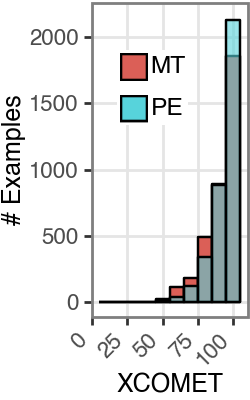

/Users/gsarti/Documents/projects/qe4pe/venv/lib/python3.11/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 1.25 x 2 in image.
/Users/gsarti/Documents/projects/qe4pe/venv/lib/python3.11/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: ../figures/xcomet_counts.pdf
/Users/gsarti/Documents/projects/qe4pe/venv/lib/python3.11/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 1.25 x 2 in image.
/Users/gsarti/Documents/projects/qe4pe/venv/lib/python3.11/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: ../figures/xcomet_counts.svg


In [122]:
xcomet_hist = plot_counts(quality_df, "mt_xcomet_qe", "pe_xcomet_qe", "XCOMET", binwidth=10, ylim_val=(0, 2150))
xcomet_hist.show()
xcomet_hist.save("../figures/xcomet_counts.pdf")
xcomet_hist.save("../figures/xcomet_counts.svg")

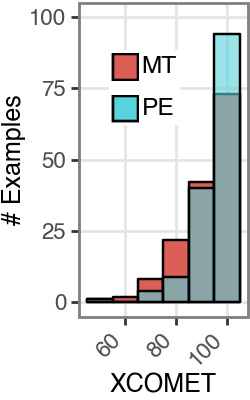

/Users/gsarti/Documents/projects/qe4pe/venv/lib/python3.11/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 1.25 x 2 in image.
/Users/gsarti/Documents/projects/qe4pe/venv/lib/python3.11/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: ../figures/xcomet_counts_agg.pdf
/Users/gsarti/Documents/projects/qe4pe/venv/lib/python3.11/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 1.25 x 2 in image.
/Users/gsarti/Documents/projects/qe4pe/venv/lib/python3.11/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: ../figures/xcomet_counts_agg.svg


In [169]:
xcomet_hist = plot_counts(merged_qa_df, "median_mt_xcomet_qe", "median_pe_xcomet_qe", "XCOMET", binwidth=10, ylim_val=(0,100))
xcomet_hist.show()
xcomet_hist.save("../figures/xcomet_counts_agg.pdf")
xcomet_hist.save("../figures/xcomet_counts_agg.svg")

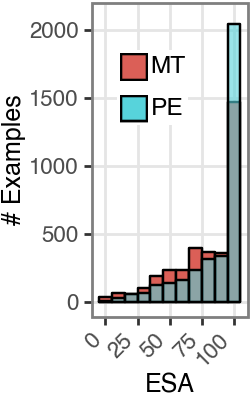

/Users/gsarti/Documents/projects/qe4pe/venv/lib/python3.11/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 1.25 x 2 in image.
/Users/gsarti/Documents/projects/qe4pe/venv/lib/python3.11/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: ../figures/esa_counts.pdf
/Users/gsarti/Documents/projects/qe4pe/venv/lib/python3.11/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 1.25 x 2 in image.
/Users/gsarti/Documents/projects/qe4pe/venv/lib/python3.11/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: ../figures/esa_counts.svg


In [123]:
esa_hist = plot_counts(quality_df, "qa_mt_esa_rating", "qa_pe_esa_rating", "ESA", binwidth=10)
esa_hist.show()
esa_hist.save("../figures/esa_counts.pdf")
esa_hist.save("../figures/esa_counts.svg")

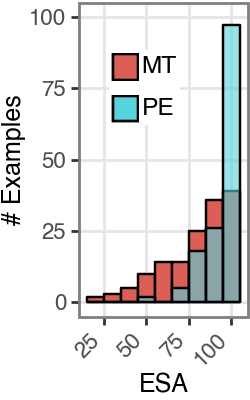

/Users/gsarti/Documents/projects/qe4pe/venv/lib/python3.11/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 1.25 x 2 in image.
/Users/gsarti/Documents/projects/qe4pe/venv/lib/python3.11/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: ../figures/esa_counts_agg.pdf
/Users/gsarti/Documents/projects/qe4pe/venv/lib/python3.11/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 1.25 x 2 in image.
/Users/gsarti/Documents/projects/qe4pe/venv/lib/python3.11/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: ../figures/esa_counts_agg.svg


In [170]:
esa_hist = plot_counts(merged_qa_df, "median_qa_mt_esa_rating", "median_qa_pe_esa_rating", "ESA", binwidth=10, ylim_val=(0,100))
esa_hist.show()
esa_hist.save("../figures/esa_counts_agg.pdf")
esa_hist.save("../figures/esa_counts_agg.svg")

In [171]:
from plotnine import guides, guide_legend

def make_quality_plot_line(
    df: pd.DataFrame,
    mode: str,
    aggregate_over: list[str] = ["highlight_modality", "wmt_category"],
    x_label: str = "MT Quality Score",
    y_label: str = "Median Edited Quality Improvement",
    prefix: str = "",
    plot_score: str = "median"
):
    if mode == "xcomet":
        plot_bins = [0, 75, 80, 85, 90, 95, 100]
        pre_var = prefix + "_" + "mt_xcomet_qe" if prefix else "mt_xcomet_qe"
        post_var = prefix + "_" + "pe_xcomet_qe" if prefix else "pe_xcomet_qe"
        title = "XCOMET"
        labels = ["< 75", "75-80", "80-85", "85-90", "90-95", "> 95"]
    elif mode == "esa":
        plot_bins = [0, 30, 40, 50, 60, 70, 80, 90, 100]
        pre_var = prefix + "_" + "qa_mt_esa_rating" if prefix else "qa_mt_esa_rating"
        post_var = prefix + "_" + "qa_pe_esa_rating" if prefix else "qa_pe_esa_rating"
        title = "ESA"
        labels = ["< 30", "30-40", "40-50", "50-60", "60-70", "70-80", "80-90", "> 90"]
    else:
        raise ValueError(f"Invalid mode: {mode}")
    df = df.assign(delta_abs_var=df[post_var] - df[pre_var])
    df['pre_var_binned'] = pd.cut(
        df[pre_var],
        bins=np.array(plot_bins),
        labels=[f"{plot_bins[i]:.2f}-{plot_bins[i + 1]:.2f}" for i in range(len(plot_bins) - 1)]
    )
    df = df.groupby(
        ['pre_var_binned'] + aggregate_over#, 'highlight_modality', 'tgt_lang', 'wmt_category']
    )["delta_abs_var"].agg([(x,x) for x in ["mean", "median", "count", "std"]]).reset_index()
    df['bin_x_score'] = df['pre_var_binned'].map(lambda x: float(x.split('-')[1]))
    df['ci_lower'] = df['median'] - (1.96 * (df['std'] / np.sqrt(df['count'])))
    df['ci_upper'] = df['median'] + (1.96 * (df['std'] / np.sqrt(df['count'])))
    df = df.replace(qe4pe_map)
    df.highlight_modality = pd.Categorical(df.highlight_modality, ordered=True, categories=["No Highlight", "Oracle", "Unsupervised", "Supervised"])
    plot = (
        ggplot(df, aes(x='bin_x_score', y=plot_score, color='highlight_modality', group='highlight_modality'))
        + geom_line(size=1)
        + geom_point(size=2)
        #+ geom_text(aes(label='count'), nudge_y=3, size=10)
        + geom_ribbon(aes(ymin='ci_lower', ymax='ci_upper', fill='highlight_modality'), alpha=0.15, color=None, linetype="")
        + geom_abline(intercept=100, slope=-1, linetype='dashed', color='black', size=0.5, alpha=0.5)
        + theme_bw()
        + labs(
            x=x_label,
            y=y_label,
            color='Highlight Modality',
            fill='Highlight Modality',
            title=title
        )
        + scale_x_continuous(breaks=plot_bins[1:], labels=labels)
        + scale_color_manual(values=["#3949f5", "#1c9a0e", "#e6950a", "#dc0d97"])
        + scale_fill_manual(values=["#3949f5", "#1c9a0e", "#e6950a", "#dc0d97"])
        + theme(
            figure_size=(5, 3),
            axis_text_x=element_text(angle=45, hjust=1),
            panel_grid_minor=element_blank(),
            legend_position='top',
            title=element_text(size=10, weight='bold'),
            legend_title=element_blank()
        )
        + guides(color=guide_legend(nrow=1))
    )
    if len(aggregate_over) == 2:
        plot = plot + facet_grid(cols=[aggregate_over[1]])
    elif len(aggregate_over) == 3:
        plot = plot + facet_grid(cols=[aggregate_over[1]], rows=[aggregate_over[2]])
    else:
        raise ValueError("aggregate_over must have 2 or 3 elements")
    return plot

/var/folders/xh/wb5mc8yn0dg3p20wq0hqtlhh0000gn/T/ipykernel_48576/3519748763.py:32: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


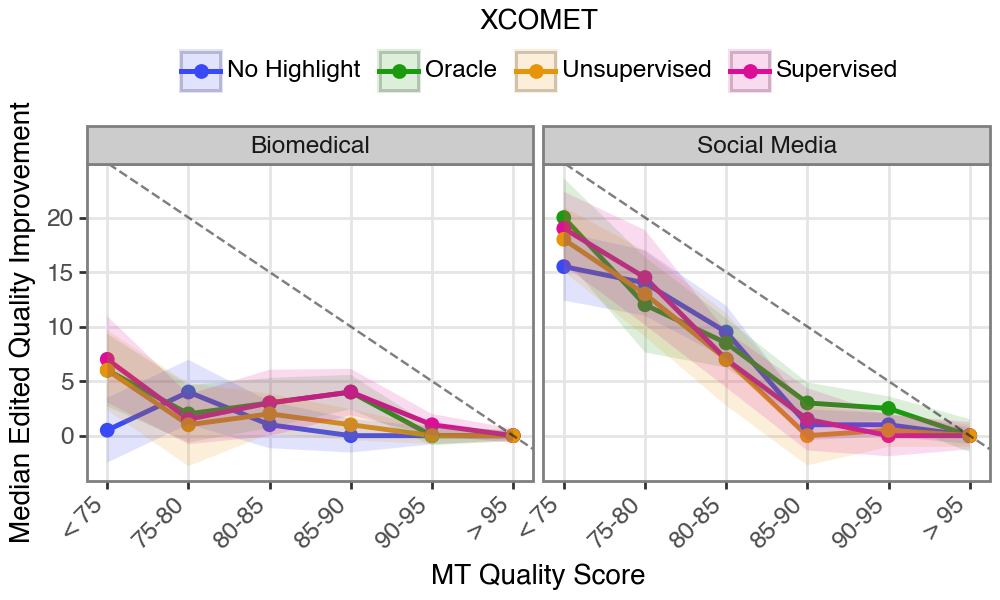

/Users/gsarti/Documents/projects/qe4pe/venv/lib/python3.11/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 5 x 3 in image.
/Users/gsarti/Documents/projects/qe4pe/venv/lib/python3.11/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: ../figures/xcomet_quality.pdf
/Users/gsarti/Documents/projects/qe4pe/venv/lib/python3.11/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 5 x 3 in image.
/Users/gsarti/Documents/projects/qe4pe/venv/lib/python3.11/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: ../figures/xcomet_quality.svg
/var/folders/xh/wb5mc8yn0dg3p20wq0hqtlhh0000gn/T/ipykernel_48576/3519748763.py:32: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


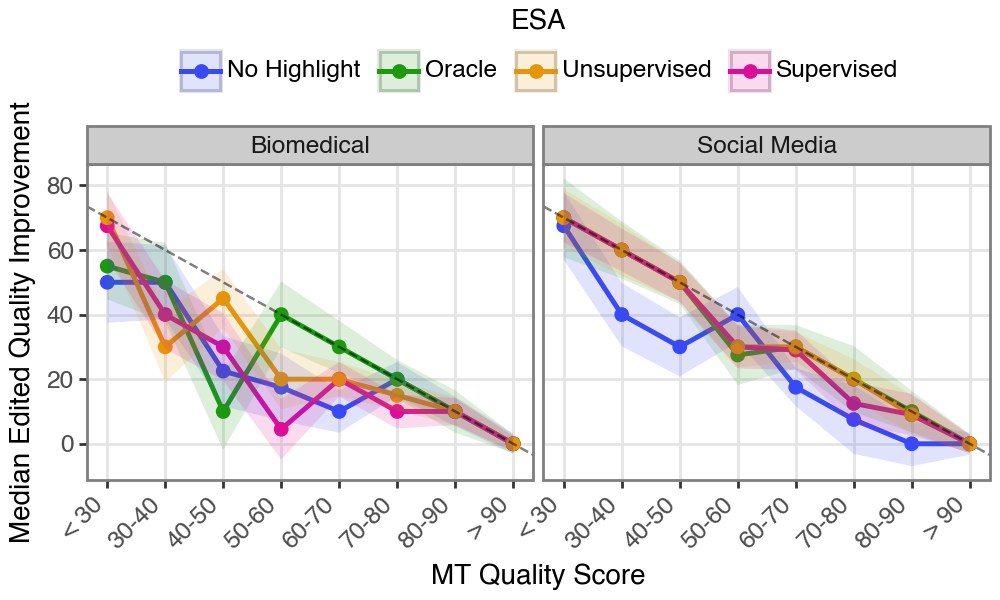

/Users/gsarti/Documents/projects/qe4pe/venv/lib/python3.11/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 5 x 3 in image.
/Users/gsarti/Documents/projects/qe4pe/venv/lib/python3.11/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: ../figures/esa_quality.pdf
/Users/gsarti/Documents/projects/qe4pe/venv/lib/python3.11/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 5 x 3 in image.
/Users/gsarti/Documents/projects/qe4pe/venv/lib/python3.11/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: ../figures/esa_quality.svg


In [172]:
xcomet_plot = make_quality_plot_line(quality_df, mode="xcomet", aggregate_over=["highlight_modality", "wmt_category"], plot_score="median")
xcomet_plot.show()
xcomet_plot.save("../figures/xcomet_quality.pdf")
xcomet_plot.save("../figures/xcomet_quality.svg")
esa_plot = make_quality_plot_line(quality_df, mode="esa", aggregate_over=["highlight_modality", "wmt_category"], plot_score="median")
esa_plot.show()
esa_plot.save("../figures/esa_quality.pdf")
esa_plot.save("../figures/esa_quality.svg")

/var/folders/xh/wb5mc8yn0dg3p20wq0hqtlhh0000gn/T/ipykernel_48576/3519748763.py:32: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


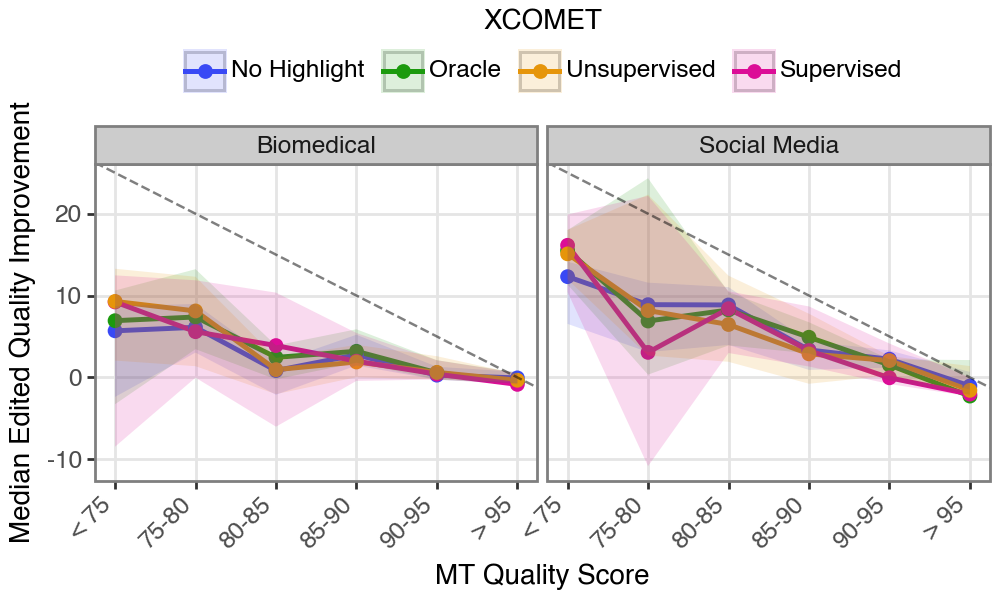

/Users/gsarti/Documents/projects/qe4pe/venv/lib/python3.11/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 5 x 3 in image.
/Users/gsarti/Documents/projects/qe4pe/venv/lib/python3.11/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: ../figures/xcomet_quality_agg.pdf
/Users/gsarti/Documents/projects/qe4pe/venv/lib/python3.11/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 5 x 3 in image.
/Users/gsarti/Documents/projects/qe4pe/venv/lib/python3.11/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: ../figures/xcomet_quality_agg.svg
/var/folders/xh/wb5mc8yn0dg3p20wq0hqtlhh0000gn/T/ipykernel_48576/3519748763.py:32: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


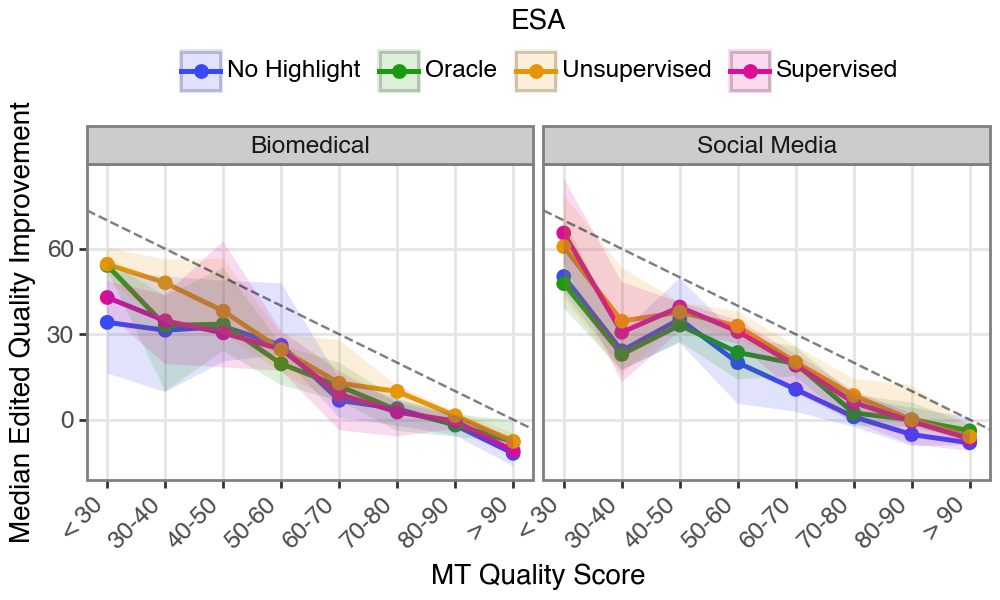

/Users/gsarti/Documents/projects/qe4pe/venv/lib/python3.11/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 5 x 3 in image.
/Users/gsarti/Documents/projects/qe4pe/venv/lib/python3.11/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: ../figures/esa_quality_agg.pdf
/Users/gsarti/Documents/projects/qe4pe/venv/lib/python3.11/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 5 x 3 in image.
/Users/gsarti/Documents/projects/qe4pe/venv/lib/python3.11/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: ../figures/esa_quality_agg.svg


In [173]:
merged_qa_df = get_merged_quality_dataframe(quality_df, aggregate_fields=["segment_id", "wmt_category", "highlight_modality"])
xcomet_plot = make_quality_plot_line(merged_qa_df, mode="xcomet", aggregate_over=["highlight_modality", "wmt_category"], prefix="mean", plot_score="mean")
xcomet_plot.show()
xcomet_plot.save("../figures/xcomet_quality_agg.pdf")
xcomet_plot.save("../figures/xcomet_quality_agg.svg")
esa_plot = make_quality_plot_line(merged_qa_df, mode="esa", aggregate_over=["highlight_modality", "wmt_category"], prefix="mean", plot_score="mean")
esa_plot.show()
esa_plot.save("../figures/esa_quality_agg.pdf")
esa_plot.save("../figures/esa_quality_agg.svg")

## MQM Error Types

In [46]:
mqm_errors_df = main[
    (~main["qa_mt_esa_rating"].isna()) & (~main["qa_pe_esa_rating"].isna())
][["translator_main_id", "tgt_lang", "highlight_modality", "wmt_category", "qa_mt_mqm_errors", "qa_pe_mqm_errors"]]
eval(mqm_errors_df.loc[1, "qa_mt_mqm_errors"])

[{'text': 'continuïteit op het gemiddelde niveau',
  'text_start': 62,
  'text_end': 99,
  'correction': 'gemiddelde continuïteit',
  'correction_start': 63,
  'correction_end': 86,
  'description': 'Mistranslation',
  'mqm_category': 'Mistranslation',
  'severity': 'Minor',
  'comment': '',
  'edit_order': 1},
 {'text': 'na 6 en 12 maanden',
  'text_start': 222,
  'text_end': 240,
  'correction': 'op de leeftijd van 6 en 12 maanden',
  'correction_start': 189,
  'correction_end': 223,
  'description': 'na 6 en 12 maanden" could be smoother if phrased as op de leeftijd van 6\n                    en 12 maanden.',
  'mqm_category': 'Readability',
  'severity': 'Minor',
  'comment': '',
  'edit_order': 2}]

In [58]:
mqm_macro_category = {
    "Mistranslation": "Accuracy",
    "Untranslated": "Accuracy",
    "Omission": "Accuracy",
    "Addition": "Accuracy",
    "Inconsistency": "Accuracy",
    "Readability": "Style",
    "Inconsistent Style": "Style",
    "Wrong Register": "Style",
    "Punctuation": "Linguistic",
    "Spelling": "Linguistic",
    "Grammar": "Linguistic",
}

def get_mqm_errors_dataframe(df: pd.DataFrame, key_fields: list[str] = ["tgt_lang", "setting", "wmt_category", "mqm_category", "mqm_macro_category", "severity"]):
    errors = {}
    for _, row in df.iterrows():
        for setting in ["mt", "pe"]:
            for error in eval(row[f"qa_{setting}_mqm_errors"]):
                error["setting"] = setting.upper()
                error["tgt_lang"] = row["tgt_lang"]
                error["wmt_category"] = row["wmt_category"]
                error["mqm_macro_category"] = mqm_macro_category[error["mqm_category"]]
                key = tuple(error[field] for field in key_fields)
                if key not in errors:
                    errors[key] = 0
                errors[key] += 1
    dicts = dict(sorted(errors.items(), key=lambda item: item[1], reverse=True))
    mqm_error_groups_df = pd.DataFrame(
        {
            "tgt_lang": [k[0] for k in dicts.keys()],
            "setting": [k[1] for k in dicts.keys()],
            "wmt_category": [k[2] for k in dicts.keys()],
            "mqm_category": [k[3] for k in dicts.keys()],
            "mqm_macro_category": [k[4] for k in dicts.keys()],
            "severity": [k[5] for k in dicts.keys()],
            "num_vals": list(dicts.values())
        }
    )
    return mqm_error_groups_df

mqm_error_groups_df = get_mqm_errors_dataframe(mqm_errors_df)
mqm_error_groups_df



,tgt_lang,setting,wmt_category,mqm_category,mqm_macro_category,severity,num_vals
0,nld,MT,biomedical,Mistranslation,Accuracy,Minor,252
1,nld,PE,biomedical,Mistranslation,Accuracy,Minor,217
2,ita,MT,social,Readability,Style,Minor,204
3,ita,MT,social,Readability,Style,Major,204
4,nld,MT,biomedical,Mistranslation,Accuracy,Major,192
...,...,...,...,...,...,...,...
157,ita,PE,social,Addition,Accuracy,Major,1
158,ita,PE,social,Spelling,Linguistic,Neutral,1
159,ita,PE,biomedical,Omission,Accuracy,Neutral,1
160,ita,PE,biomedical,Inconsistent Style,Style,Minor,1


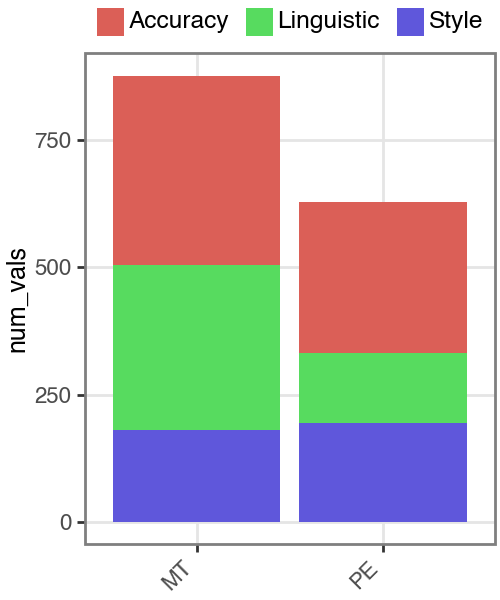

/Users/gsarti/Documents/projects/qe4pe/venv/lib/python3.11/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 2.5 x 3 in image.
/Users/gsarti/Documents/projects/qe4pe/venv/lib/python3.11/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: ../figures/mqm_errors_biomed.pdf
/Users/gsarti/Documents/projects/qe4pe/venv/lib/python3.11/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 2.5 x 3 in image.
/Users/gsarti/Documents/projects/qe4pe/venv/lib/python3.11/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: ../figures/mqm_errors_biomed.svg


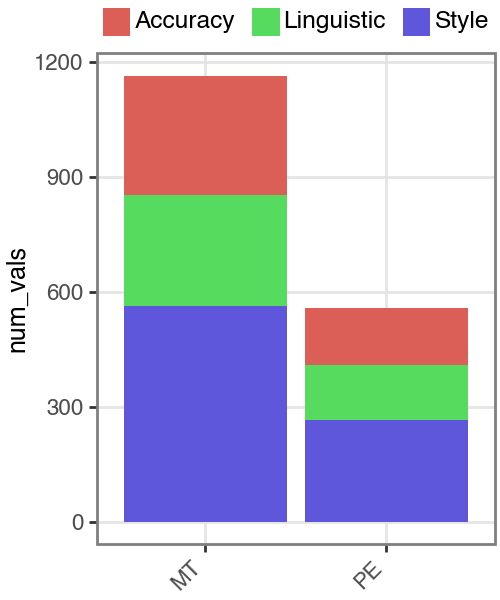

/Users/gsarti/Documents/projects/qe4pe/venv/lib/python3.11/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 2.5 x 3 in image.
/Users/gsarti/Documents/projects/qe4pe/venv/lib/python3.11/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: ../figures/mqm_errors_social.pdf
/Users/gsarti/Documents/projects/qe4pe/venv/lib/python3.11/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 2.5 x 3 in image.
/Users/gsarti/Documents/projects/qe4pe/venv/lib/python3.11/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: ../figures/mqm_errors_social.svg


In [74]:
from plotnine import geom_col


def plot_bars(df, filters, field):
    return (
        ggplot(df[filters], aes('setting', 'num_vals', fill=field))
        + geom_col()
        + theme_bw()
        + theme(
            figure_size=(2.5, 3),
            panel_grid_minor=element_blank(),  # Remove minor gridlines
            axis_title=element_text(size=9),
            axis_text=element_text(size=8),
            axis_title_x=element_blank(),
            legend_title=element_blank(),
            legend_position="top",
            legend_key_size=10,
            legend_key_spacing_y=5,
            axis_text_x=element_text(angle=45, hjust=1),
        )
    )

filtering_biomed = (mqm_error_groups_df["wmt_category"] == "biomedical") & (mqm_error_groups_df["tgt_lang"] == "ita")
bars_biomed = plot_bars(mqm_error_groups_df, filtering_biomed, "mqm_macro_category")
bars_biomed.show()
bars_biomed.save("../figures/mqm_errors_biomed.pdf")
bars_biomed.save("../figures/mqm_errors_biomed.svg")
filtering_social = (mqm_error_groups_df["wmt_category"] == "social") & (mqm_error_groups_df["tgt_lang"] == "ita")
bars_social = plot_bars(mqm_error_groups_df, filtering_social, "mqm_macro_category")
bars_social.show()
bars_social.save("../figures/mqm_errors_social.pdf")
bars_social.save("../figures/mqm_errors_social.svg")
